In [1]:
#various imports
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,BatchNormalization,Concatenate, Lambda#,concatenate
import tensorflow.keras as keras
K = keras.backend
import math
import seaborn as sns
import random
import time
import tensorflow as tf

In [2]:
#nicer plotting style
plt.rcParams.update({'font.size': 30,
                    'font.family':  'Times New Roman',
                    'legend.edgecolor': 'black',
                    'xtick.minor.visible': True,
                    'ytick.minor.visible': True,
                    'xtick.major.size':15,
                    'xtick.minor.size':10,
                    'ytick.major.size':15,
                     'ytick.minor.size':10})

The next cell defines a bunch of helper functions to create the toy tracker. The tracker is defined as a set of 4 layers each containing a given number of cells (arguments width in x, height in y). A hit represents a cluster, for example this could be the most energetic cell of a cluster.

A track is generated by randomly generating a hit in each of the first two layers then using the 3D line equation to find the position of the hits in the last two layers. At the moment we only keep tracks that have hits in all 4 layers. The position of each hit in a track can additionally be smeared (argument res). A track is represented by an array of size (1,8) containing (x_layer1,y_layer1,...,x_layer4,y_layer4). Tracks can be distorted by randomly shifting the position of a hit in a layer chosen at random. Tracks can be scaled so that instead of being a number going from 0 to width or 0 to height these are numbers going from 0-1.

An event is created by generating N tracks (argument nbTracks) and adding N noisy hits pers layer (argument nbNoise). The tracks can be required to not overlap (ie so they don't share a cell in any layer, argument allow_overlap). The event will then be represented by an array of size (width,height,4) containing all hits in each layer and a series of  true tracks. Events can be plotted using the event array. Noise in the event array i represented by -1 and true tracks are represented as 1. All possible track combinations can then be returned from the event_array. This quickly becomes slow when more noise or tracks are added to the event

In [3]:
# generates a line
# arguments: size in z,x,y
# returns a track as an array size (8) containing (x_layer1,y_layer1,...,x_layer4,y_layer4).
def genLine(depth,width,height):
    x1=random.randint(0,width-1)
    y1=random.randint(0,height-1)
    z1=0*depth
    x2=random.randint(0,width-1)
    y2=random.randint(0,height-1)
    z2=1*depth
    
    l=(x2 - x1)
    m=(y2 - y1)
    n=(z2 - z1)
    # (x – x1)/l = (y – y1)/m = (z – z1)/n
    z3=2*depth
    x3=l*((z3-z1)/n)+x1
    y3=m*((z3-z1)/n)+y1
    
    z4=3*depth
    x4=l*((z4-z1)/n)+x1
    y4=m*((z4-z1)/n)+y1
    
    return np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))

# checks if all hits in a track are within the layer
# arguments: a track and the x,y size of the layers
# returns true if the track is contained in the detector, false otherwise
def check_acceptance(track,width,height):
    track_in_det=False
    
    #loop over all hits
    for i in range(0,len(track),2):
        #print(track[i])
        #print(track[i+1])
        
        #check if hit is within the detector
        if track[i]>0 and track[i]<width:
            if track[i+1]>0 and track[i+1]<height:
                track_in_det=True
            else:
                track_in_det=False
        else:
            track_in_det=False
    return track_in_det

# smears a track by adding a value randomly sampled from a gaussian with mean 0, standard deviation res
# arguments: the track to be smeared and the standard deviation of the gaussian, x,y size ofthe layers
# returns: smeared track
def smear(track,res,width,height):
    if res!=0:
        track=track+np.random.normal(0,res,8)
    #check track hasn't been smeared out of layer
    for i in range(0,8,2):
        #if the track is a number between width-0.5 and width it'll be rounded to width
        #layer size goes from 0 to width-1 so recast as width-1
        #same with height
        if track[i]>(width-1):
            track[i]=width-1
        if track[i]<0:
            track[i]=0
        if track[i+1]>(height-1):
            track[i+1]=height-1
        if track[i+1]<0:
            track[i+1]=0 
            
    #print(track)
    #print(np.rint(track).astype(int))
    #need to cast the array to integers as smearing can be float
    return np.rint(track).astype(int)
    

# generate a track by generating a line, checking that the track is in the detector and smearing the track
# arguments: z,x,y size of detector and resolution
# returns: a smeared track in the detector
def genTrack(depth,width,height,res):
    track=np.zeros((1,8))
    track_in_det=False
    while track_in_det==False:
        track=genLine(depth,width,height)    
        track_in_det=check_acceptance(track,width,height)
        
    return smear(track,res,width,height)

# scale an array of tracks between 0 and 1
# arguments: array of tracks, x/y size of layers.
# returns: an array of scaled tracks
def norm(X,width,height):
    X=X.astype(np.float64)
    X[:,0]=X[:,0]/width
    X[:,1]=X[:,1]/height
    X[:,2]=X[:,2]/width
    X[:,3]=X[:,3]/height
    X[:,4]=X[:,4]/width
    X[:,5]=X[:,5]/height
    X[:,6]=X[:,6]/width
    X[:,7]=X[:,7]/height
    return X

# unscale an array of tracks between 0 and 1
# arguments: array of tracks, x/y size of layers.
# returns: an array of unscaled tracks
def unnorm(X,width,height):
    X=X.astype(np.float32)
    X[:,0]=X[:,0]*width
    X[:,1]=X[:,1]*height
    X[:,2]=X[:,2]*width
    X[:,3]=X[:,3]*height
    X[:,4]=X[:,4]*width
    X[:,5]=X[:,5]*height
    X[:,6]=X[:,6]*width
    X[:,7]=X[:,7]*height
    return X.astype(int)

# adds noise to an event by randomly picking N points in each layer, noise are set to -1 in the event array
# arguments: x,y size of layers, the array containing all layers, the amount of noisy hits to add
# returns: the array containing all layers with added noise
def noiseEvent(width,height,event_lattice,nbNoise):
    for layer in range(0,4):
        randomX=np.random.randint(0,width-1, size=nbNoise, dtype=int)
        randomY=np.random.randint(0,height-1, size=nbNoise, dtype=int)
        for i in range(0,nbNoise):
            event_lattice[randomX[i],randomY[i],layer]=-1 #allows to see noise in plots
    return event_lattice

# plots a single layer of the tracker
# arguments: the layer, x,y size of the layer, how often to add ticks (ie every N), the event canvas containing
# all layers, the layer number
def plotLayer(layer,width,height,ticks,axes,i):
    #fig=plt.figure(figsize = (20,20))
    sns.heatmap(layer,ax=axes[i],cmap='vlag_r', vmin=-1, vmax=1)
    for ind, label in enumerate(axes[i].get_xticklabels()):
        if (ind % ticks) == 0:  # every Nth label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    for ind, label in enumerate(axes[i].get_yticklabels()):
        if (ind % ticks) == 0:  # every Nth label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    #axes[i].invert_yaxis()
    axes[i].set(xlabel='x [AU]')
    axes[i].set(ylabel='y[AU]')
    #plt.show()

# plots an event as a series of heatmaps representing each layer in one canvas
# arguments: the array containing all layers, x,y size of the layer, how often to add ticks (ie every N)
def plotEvent(event_lattice,width,height,ticks):
    fig, axes = plt.subplots(1, 4, figsize=(40, 7))#, sharey=True)
    fig.suptitle('Tracker Layers 1 to 4')
    for i in range(0,4):
        plotLayer(event_lattice[:,:,i],width,height,ticks,axes,i)
    plt.show()
     
# distorts in track in an array of tracks by randomly shifting the position of a hit in a randomly chosen layer
# arguments: array of tracks, x,y size of the layers
# returns: array of distorted tracks, same size as the array of original tracks
def distort_tracks(tracks,width,height):
    
    fake_tracks=tracks.copy()
    
    #loop over tracks
    for i in range(fake_tracks.shape[0]):
        #choose layer to distort at random
        layer=np.random.randint(0,4, size=1, dtype=int)
        new_x=fake_tracks[i,2*layer]
        new_y=fake_tracks[i,2*layer+1]
        #make sure you don't accidentally pick same x,y position
        while new_x==fake_tracks[i,2*layer]:
            new_x=np.random.randint(0,width-1, size=1, dtype=int)
        while new_y==fake_tracks[i,2*layer]:
            new_y=np.random.randint(0,height-1, size=1, dtype=int)
        fake_tracks[i,2*layer]=new_x[0]
        fake_tracks[i,2*layer+1]=new_y[0]
        
    
    return fake_tracks

# add an array of tracks to the array containing all layers
# arguments: array containg all layers, array containing tracks, whether to add tracks as 1 or -1 to array containg
# all layers, this allows to ID noise as -1 and true hits as 1
def addTracks(event_lattice,tracks,sign):
    for i in range(0,tracks.shape[0]):
        addTrack(event_lattice,tracks[i],sign)

# add a single track to the array containg all layers
# arguments: array containg all layers, track, whether to add tracks as 1 or -1 to array containg
# all layers, this allows to ID noise as -1 and true hits as 1
def addTrack(event_lattice,track,sign):
    for j in range(0,len(track),2):
        #track[j+1]=y, track[j]=x, numpy array filled with a[y,x]
        
        #only fill unempty cells
        if event_lattice[track[j+1],track[j],round(j/2)]==0:
            event_lattice[track[j+1],track[j],round(j/2)]=sign
        
    return event_lattice

# find hits (ie non-zero element) in a given layer
# arguments: array containg all hits in a layer
# returns: array containg all x,y position of hits in a layer
def find_hits(layer):
    nz=np.nonzero(layer) #nz[1] corresponds to x pos (columns),nz[0] corresponds to y pos (rows)
    hits=np.hstack((nz[1].reshape((len(nz[1]),1)),nz[0].reshape((len(nz[0]),1))))
    #print(hits)
    return hits

# find hits (ie non-zero element) in a given layer, scale the output array between 0 and 1
# arguments: array containg all hits in a layer, x,y size of layers
# returns: array containg all x,y position of hits in a layer scaled between 0 and 1
def find_hits_normed(layer,width,height):
    nz=np.nonzero(layer) #nz[1] corresponds to x pos (columns),nz[0] corresponds to y pos (rows)
    nz_x=nz[1].reshape((len(nz[1]),1)).astype(np.float64)
    nz_y=nz[0].reshape((len(nz[0]),1)).astype(np.float64)
    hits=np.hstack((nz_x/width,nz_y/height))
    #print(hits)
    return hits



# find all track candidates in an event, ID if these are true tracks or fake tracks. IDing tracks is slow and should
# only be used for training. An argument allows to decide whether or not to ID tracks
# arguments: array containg all layers, array containing all true tracks, whether or not we want to label tracks
# as true or false.
# returns: all possible tracks and array containing label as to whether a track is true or fake, this will be
# non meaningful if the argument meaningful_labels==False
def find_track_candidates(event_lattice,tracks,meaningful_labels):
    hits_l0=find_hits(event_lattice[:,:,0])
    hits_l1=find_hits(event_lattice[:,:,1])
    hits_l2=find_hits(event_lattice[:,:,2])
    hits_l3=find_hits(event_lattice[:,:,3])
    
    new_tracks=np.zeros((1,8))
    
    n_tracks=0
    #create all permutations of hits in layer
    for l0 in hits_l0:
        for l1 in hits_l1:
            for l2 in hits_l2:
                for l3 in hits_l3:
                    track=np.hstack((l0,l1,l2,l3))
                    if n_tracks==0:
                        new_tracks=track
                    else:
                        new_tracks=np.vstack((new_tracks,track))
                    n_tracks=n_tracks+1
                    
    #print(new_tracks)
    
    #label array has two column per row. 
    #first column is 1 for fake tracks, 0 for true tracks. second column is 0 for fake tracks, 1 for true
    label=np.ones((new_tracks.shape[0],1))
    label=np.hstack((label,np.zeros((new_tracks.shape[0],1))))
    
    if meaningful_labels==True:
        for i in range(0,new_tracks.shape[0]):
            for j in range(0,tracks.shape[0]):
                #print(new_tracks[i])
                #print(tracks[j])
                if(np.array_equal(new_tracks[i],tracks[j])):
                    label[i,0]=0
                    label[i,1]=1
            
    #print(label)
    
    return new_tracks, label

#check if a track overlaps with an array of tracks
# argument: track and array of tracks
# returns: True if there's no overlap, False otherwise
def check_no_overlap(track,all_tracks):
    no_overlap=True
    for i in range(0,all_tracks.shape[0]):
        for j in range(0,8,2):
            #overlap defined as tracks sharing a hit
            if track[j]==all_tracks[i,j] and track[j+1]==all_tracks[i,j+1]:
                no_overlap=False
    return no_overlap
    
# generate an event containg a given number of tracks and noisy hits per layer
# arguments: size in z,x,y, number of tracks to generate, amount of smearing on hit position in tracks
# number of noisy hits per layer, True if want to allow tracks to share a hit, false otherwise
# returns: an array containing all true tracks and an array containing all layers
def genEvent(depth,width,height,nbTracks,res,nbNoise,allow_overlap):
    all_tracks=np.zeros((1,8))
    event_lattice=np.zeros((height,width,4))
    nbGenTracks=0
    while nbGenTracks<nbTracks:
        track=genTrack(depth,width,height,res)
        
        keep_track=True
        if allow_overlap==False and nbGenTracks>0:
            keep_track=check_no_overlap(track,all_tracks)
            
        if keep_track==True:
            event_lattice=addTrack(event_lattice,track,1)
            
            if nbGenTracks==0:
                all_tracks=track.reshape(1,8)
            else:
                all_tracks=np.vstack((all_tracks,track))
            nbGenTracks=nbGenTracks+1
            
    event_lattice=noiseEvent(width,height,event_lattice,nbNoise)

    return all_tracks, event_lattice
        
    

The follow cell demonstrates how to generate an event and how to plot this.
First we pick a size for the tracker, the amount of tracks to generate, the smearing on hit position in tracks, how many noisy hits to add per layer, how often to plot x/y ticks and if we want tracks to share a hit position.
Then we get the true tracks and an array of size (width,height,4) containing all hits in each layer.
We can distort true tracks, this could be used to train an algorithm to distinguish between true and false tracks. We can add these tracks to the array containing all layers then plot the event.
We then find all track candidates which are permutations based on hits in each layer.

(20, 20, 4)
True Tracks
[[11 18  8 15  5 12  2  9]
 [12 16 12 17 12 18 12 19]]
Distorted Tracks
[[11 18 17 15  5 12  2  9]
 [12 16 12 17  5 18 12 19]]


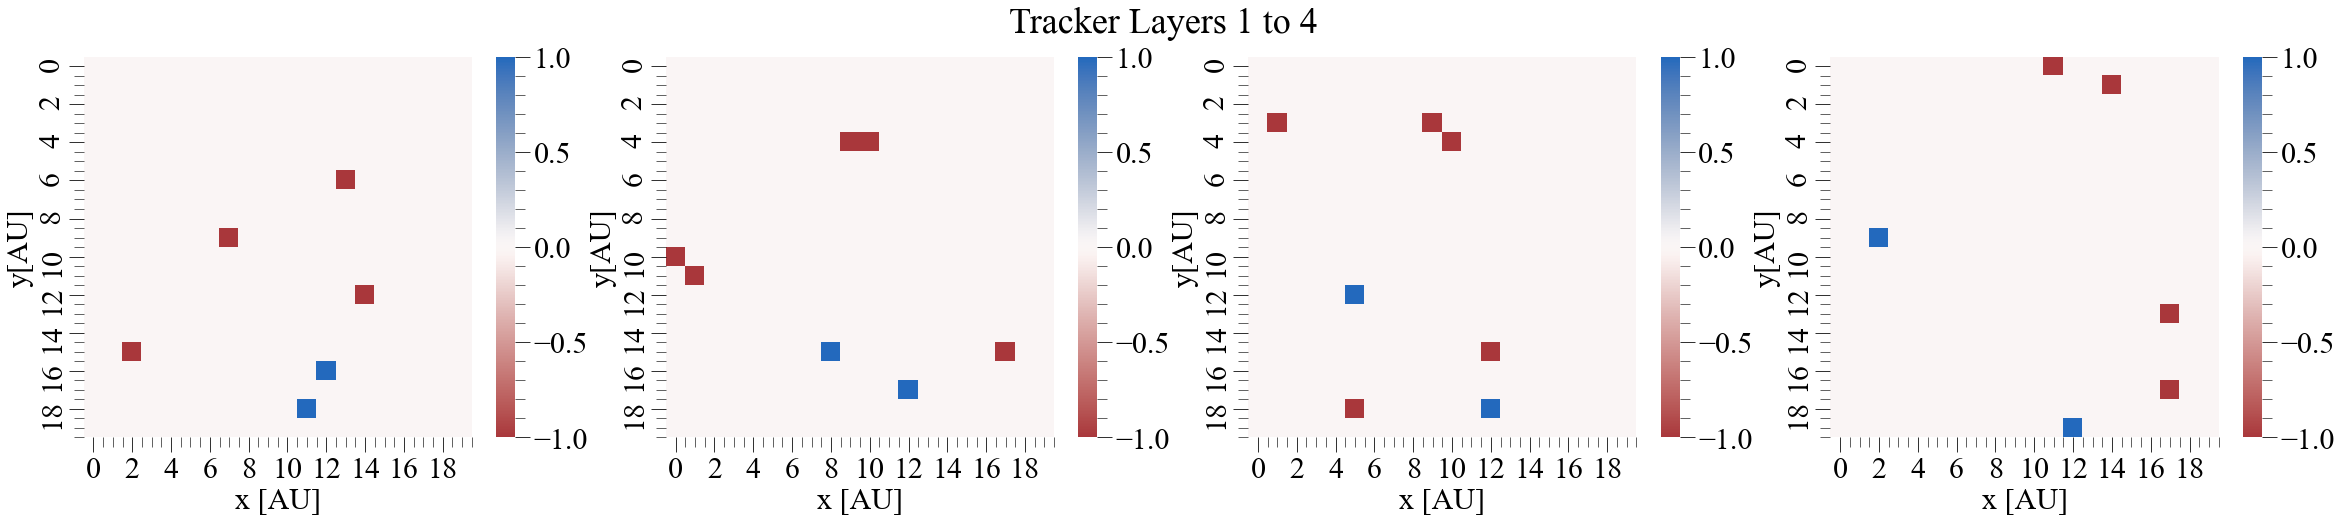

True Tracks from all Candidates
[[12 16 12 17 12 18 12 19]
 [11 18  8 15  5 12  2  9]]


In [4]:
width=20
height=20
depth=5*width

nbTracks=2

resolution=0#(width/10)
nbNoise=4#round((width*height)/10)

ticks=1

allow_overlap=False

true_tracks,event_array=genEvent(depth,width,height,nbTracks,resolution,nbNoise,allow_overlap)

print(event_array.shape)

distorted_tracks=distort_tracks(true_tracks.copy(),width,height)
print('True Tracks')
print(true_tracks)
print('Distorted Tracks')
print(distorted_tracks)

addTracks(event_array,distorted_tracks,-1)

plotEvent(event_array,width,height,ticks)

track_candidates,labels=find_track_candidates(event_array,true_tracks,True)

print('True Tracks from all Candidates')
print(track_candidates[labels[:,1]==1])

The following cell has a bunch of helper function to train an algorithm to identify true tracks as is done at CLAS12 (see arXiv:2202.06869).

Then we define code to train a neural network to ID true tracks. We can then apply this algorithm in two ways. Either we return all tracks for which the output (response) of the neural network is above a given threshold and discard all else, or we rank tracks in order of the response and remove track candidates that share hits with tracks that have a higher response than them. The second ensures no two tracks will share a hit but is slower.

Finally we can calculate some metrics. For example the efficiency which tells us how good the algorithm is at preserving true tracks or the fraction of fake tracks that survive the algorithm. We want the first to be as close as possible to 1 and the second to be as close as possible to 0.

In [ ]:
# train a neural network to identify true tracks.
# arguments: list of track candidates, labels to know if this is a true or fake track, number of training epochs
# returns: the trained neural network
def train_trackID(track_candidates,labels,nEpochs):
    
    #make sure that there are as many true tracks as there are false. Otherwise the classifier might be biased.
    X,y=balance_dataset(track_candidates,labels)
    
    #split tracks into a training or testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=5)
    
    print('Train/test sample shape for true tracks')
    print(X_train[y_train[:,1]==1].shape)
    print(X_test[y_test[:,1]==1].shape)
    print('Train/test sample shape for fake tracks')
    print(X_train[y_train[:,1]==0].shape)
    print(X_test[y_test[:,1]==0].shape)
    
    #define neural network architecture
    model = Sequential()
    model.add(Dense(track_candidates.shape[1],input_dim=track_candidates.shape[1], activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, activation='softmax')) #lat layer has two nodes, one for false track, one for true track
    
    opti=Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=opti,metrics=["accuracy"])
    model.summary()
    
    #train
    history=model.fit(X_train,y_train,epochs=nEpochs, validation_data=(X_test, y_test), verbose=2)
    
    #plot loss as a function of training epoch
    fig = plt.figure(figsize=(20, 20))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    #plot the output (ie response) of the neural network on the testing set
    plot_trackID_response(model,X_test,y_test)
    
    return model

# make sure there is as many true and fake tracks in a dataset
# arguments: list of track candidates, labels to know if this is a true or fake track
# returns: balanced list of track candidates, labels to know if this is a true or fake track
def balance_dataset(track_candidates,labels):
    X_pos=track_candidates[labels[:,1]==1]
    X_neg=track_candidates[labels[:,1]==0]
    y_pos=labels[labels[:,1]==1]
    y_neg=labels[labels[:,1]==0]
    
    #randomly shuffle the arrays as sometimes these have all fake tracks at the end
    p_pos = np.random.permutation(len(X_pos))
    p_neg = np.random.permutation(len(X_neg))
    
    X_pos=X_pos[p_pos]
    y_pos=y_pos[p_pos]
    X_neg=X_neg[p_neg]
    y_neg=y_neg[p_neg]
    
    #check if we have more fake or true tracks
    if(len(X_neg)>len(X_pos)):
        X_neg=X_neg[0:len(X_pos),:]
        y_neg=y_neg[0:len(X_pos),:]
    else:
        X_pos=X_pos[0:len(X_neg),:]
        y_pos=y_pos[0:len(X_neg),:]
        
    #print(X_pos.shape)
    #print(X_neg.shape)
        
    return np.vstack((X_pos,X_neg)),np.vstack((y_pos,y_neg))

# plot the response of the neural network when predicting on a set of tracks
# arguments: the neural network, list of track candidates, labels to know if this is a true or fake track
def plot_trackID_response(track_identifier,track_candidates,labels):
    y_pred = track_identifier.predict(track_candidates)[:, 1]
    y=labels[:, 1]
    
    fig = plt.figure(figsize=(20,20))
    plt.hist(y_pred[y==1], range=[0,1],bins=100,color='royalblue', label='True Tracks')#, range=[2.7,3.3]
    plt.hist(y_pred[y==0], range=[0,1],bins=100, edgecolor='firebrick',label='False Tracks',hatch='/',fill=False)
    plt.legend(loc='upper center')#can change upper to lower and center to left or right
    plt.xlabel('Response')
    plt.yscale('log', nonpositive='clip')
    plt.title('Track ID Response')
    plt.show()
    
# apply track identification by only keeping tracks above a certain threshold
# arguments: the neural network, list of track candidates, the threshold on the response
# returns: array of track to keep and array of tracks to throw away
def apply_trackID_cutResp(track_identifier,track_candidates,resp_th):
    #get the response for the set of tracks
    y_pred = track_identifier.predict(track_candidates)[:, 1]
    kept_tracks=track_candidates[y_pred>=resp_th]
    rejected_tracks=track_candidates[y_pred<resp_th]
        
    return kept_tracks,rejected_tracks

# apply track identification by only keeping track with highest response by discarding
# tracks that share hits with tracks that have a higher response than them
# arguments: the neural network, list of track candidates
# returns: array of track to keep and array of tracks to throw away
def apply_trackID(track_identifier,track_candidates):
    #get the response for the set of tracks
    y_pred = track_identifier.predict(track_candidates)[:, 1]
     
    #sort tracks and response by the response going from lowest to highest
    sort = np.argsort(y_pred)
    y_pred=y_pred[sort]
    track_candidates=track_candidates[sort]
    
    kept_tracks=np.zeros((1,8))
    rejected_tracks=np.zeros((1,8))
    
    #ID which selected track we're comparing to
    track_number=0
    
    #keep going until we have no tracks left
    while track_candidates.size != 0:
        
        #last track in array has highest response
        if track_number==0:
            kept_tracks=track_candidates[-1].reshape(1,8)
        else:
            kept_tracks=np.vstack((kept_tracks,track_candidates[-1]))
         
        #keep all tracks except the one with the highest response
        track_candidates=track_candidates[:-1]
        
        rows_to_del=[]
        #loop over tracks
        for i in range(0,track_candidates.shape[0]):
            to_del=False
            #loop over hits in track
            for j in range(0,8,2):
                #discard track if it shares a hit with the selected track
                if kept_tracks[track_number,j]==track_candidates[i,j] and kept_tracks[track_number,j+1]==track_candidates[i,j+1]:
                    to_del=True
            if to_del==True:
                rows_to_del.append(i)
        
        #keep the tracks we're rejecting
        if track_number==0:
            rejected_tracks=track_candidates[rows_to_del, :]
        else:
            rejected_tracks=np.vstack((rejected_tracks,track_candidates[rows_to_del, :]))
        track_candidates=np.delete(track_candidates, rows_to_del, axis=0)
                
        track_number=track_number+1
        
    return kept_tracks,rejected_tracks
    
# calculate the fraction of true and fake tracks that are selected by the alogrithm
# arguments: arrays of true tracks, selected tracks and rejected tracks
def calculate_metrics(true_tracks,selected_tracks,rejected_tracks):
    TP=0
    FP=0
    FN=0
    
    # check if a true track is in the selected tracks
    for i in range(0,selected_tracks.shape[0]):
        matched=False
        for j in range(0,true_tracks.shape[0]):
            #print(new_tracks[i])
            #print(tracks[j])
            if(np.array_equal(selected_tracks[i],true_tracks[j])):
                matched=True
        if matched==True:
            TP=TP+1
        else:
            FP=FP+1
        
    #check if a true track is in the rejected tracks
    for i in range(0,rejected_tracks.shape[0]):
        matched=False
        for j in range(0,true_tracks.shape[0]):
            #print(new_tracks[i])
            #print(tracks[j])
            if(np.array_equal(rejected_tracks[i],true_tracks[j])):
                matched=True
        if matched==True:
            FN=FN+1
            
    eff=TP/(TP+FN)
    bg_eff=FP/(selected_tracks.shape[0]+rejected_tracks.shape[0]-true_tracks.shape[0])
    
    return eff,bg_eff
    

In this cell we're showing how to normalise tracks so each element is between 0 and 1

In [ ]:
norm_true_tracks=norm(true_tracks.copy(),width,height) #use copy argument to avoid changing true_tracks
unnormed_true_tracks=unnorm(norm_true_tracks.copy(),width,height)

print('True Tracks')
print(true_tracks)
print('Normalised tracks')
print(norm_true_tracks)
print('Unnormalised tracks')
print(unnormed_true_tracks)

In the next two cells we're showing how to train an algorithm to ID true tracks. From simple tests it was found that when training the neural network on true tracks and fake tracks created by distorting true tracks the neural network performed less well on all track candidates taken from permutations of hits in the layers. Instead it's better to train the neural network on the true and fake tracks taken directly from these permutations.

In [ ]:
nb_train_events=10000

#training set of track candidates and labels
train_tracks=np.zeros((1,8))
train_labels=np.zeros((1,8))

for i in range(nb_train_events):
    
    if (i%500)==0:
        print('Generated '+str(i)+' events')
    
    true_tracks,event_array=genEvent(depth,width,height,nbTracks,resolution,nbNoise,allow_overlap)
    
    #can distort tracks, this is faster but didn't work as well
    
    #distorted_tracks=distort_tracks(true_tracks.copy(),width,height)
    #labels_pos=np.zeros((true_tracks.shape[0],1))
    #labels_pos=np.hstack((labels_pos,np.ones((true_tracks.shape[0],1))))
    #labels_neg=np.ones((distorted_tracks.shape[0],1))
    #labels_neg=np.hstack((labels_neg,np.zeros((distorted_tracks.shape[0],1))))
    
    #if i==0:
    #    train_tracks=np.vstack((true_tracks,distorted_tracks))
    #    train_labels=np.vstack((labels_pos,labels_neg))
    #else:
    #    train_tracks=np.vstack((train_tracks,true_tracks,distorted_tracks))
    #    train_labels=np.vstack((train_labels,labels_pos,labels_neg))
    
    #add track candidates and labels to training set
    track_candidates,labels=find_track_candidates(event_array,true_tracks,True)
    #balance dataset here to avoid keeping loads of fake tracks we won't use
    track_candidates,labels=balance_dataset(track_candidates,labels)
    if i==0:
        train_tracks=track_candidates
        train_labels=labels
    else:
        train_tracks=np.vstack((train_tracks,track_candidates))
        train_labels=np.vstack((train_labels,labels))


In [ ]:
print(train_tracks.shape)
train_tracks=norm(train_tracks,width,height)
#train classifier, 50 epochs ok without smearing, 100 otherwise
track_identifier=train_trackID(train_tracks,train_labels,100)

In this cell we're showing how to apply the neural network to track candidates created from permutations of hits in layers. For the first event we print the array of true, selected and rejected tracks and we plot the event and the selected tracks only. We then print the metrics averaged over all events.

In [ ]:
nb_test_events=1000

AvEff=0
AvPur=0

AvEff_cr=0
AvPur_cr=0

AvTime_getEvent=0
AvTime_getCandidates=0
AvTime_apply=0
AvTime_apply_cr=0

AvNbTracks=0

for i in range(nb_test_events):
    
    if (i%100)==0:
        print('Generated '+str(i)+' events')

    #timing to get an event
    t0_getEvent = time.time()
    
    #generate event
    true_tracks,event_array=genEvent(depth,width,height,nbTracks,resolution,nbNoise,allow_overlap)
    
    t1_getEvent = time.time()
    AvTime_getEvent=AvTime_getEvent+(t1_getEvent-t0_getEvent)

    #timing to find track candidates (not requiring meaningful labels)
    t0_getCandidates = time.time()
    
    track_candidates,labels=find_track_candidates(event_array,true_tracks,False)
    
    t1_getCandidates = time.time()
    AvTime_getCandidates=AvTime_getCandidates+(t1_getCandidates-t0_getCandidates)
    
    #number of tracks per event
    AvNbTracks=AvNbTracks+track_candidates.shape[0]
    
    #normalise track candidates
    track_candidates=norm(track_candidates,width,height)
    
    #timing to apply ID selecting only tracks with best response
    t0_apply = time.time()
    
    #apply track identification selecting only tracks with best response
    selected_tracks,rejected_tracks=apply_trackID(track_identifier,track_candidates.copy())
    
    t1_apply = time.time()
    AvTime_apply=AvTime_apply+(t1_apply-t0_apply)
    
    #timing to apply ID when cutting on the response
    t0_apply_cr = time.time()
    
    selected_tracks_cr,rejected_tracks_cr=apply_trackID_cutResp(track_identifier,track_candidates.copy(),0.9)
    
    t1_apply_cr = time.time()
    AvTime_apply_cr=AvTime_apply_cr+(t1_apply_cr-t0_apply_cr)

    #unnorm selected and rejected tracks
    selected_tracks=unnorm(selected_tracks,width,height)
    rejected_tracks=unnorm(rejected_tracks,width,height)
    #unnorm selected and rejected tracks
    selected_tracks_cr=unnorm(selected_tracks_cr,width,height)
    rejected_tracks_cr=unnorm(rejected_tracks_cr,width,height)
    
    #print the first event
    if i==0:
        print('')
        print('True Tracks, size: '+str(true_tracks.shape[0]))
        print(true_tracks)
        print('')
        print('Selected Tracks, size: '+str(selected_tracks_cr.shape[0]))
        print(selected_tracks_cr)
        print('')
        print('Rejected Tracks, size: '+str(rejected_tracks_cr.shape[0]))
        print(rejected_tracks_cr)
        print('')
        event_array_2=np.zeros((height,width,4))
        addTracks(event_array_2,selected_tracks_cr,1)
        plotEvent(event_array,width,height,ticks)
        plotEvent(event_array_2,width,height,ticks)

    #get metrics, these will be averaged over all events
    eff,pur=calculate_metrics(true_tracks,selected_tracks,rejected_tracks)
    eff_cr,pur_cr=calculate_metrics(true_tracks,selected_tracks_cr,rejected_tracks_cr)
    #print(eff)
    #print(pur)
    AvEff=AvEff+eff
    AvPur=AvPur+pur
    AvEff_cr=AvEff_cr+eff_cr
    AvPur_cr=AvPur_cr+pur_cr
    
#average metrics, nb of tracks and times
AvEff=AvEff/nb_test_events
AvPur=AvPur/nb_test_events

AvEff_cr=AvEff_cr/nb_test_events
AvPur_cr=AvPur_cr/nb_test_events


AvTime_getEvent=AvTime_getEvent/nb_test_events
AvTime_getCandidates=AvTime_getCandidates/nb_test_events
AvTime_apply=AvTime_apply/nb_test_events
AvTime_apply_cr=AvTime_apply_cr/nb_test_events

AvNbTracks=AvNbTracks/nb_test_events

print('')
print('Fraction of true tracks that survive '+str(AvEff))
print('Fraction of false tracks that survive '+str(AvPur))
print('')
print('Fraction of true tracks that survive '+str(AvEff_cr)+' with Resp>0.9')
print('Fraction of false tracks that survive '+str(AvPur_cr)+' with Resp>0.9')

print('')
print('On average had '+str(AvNbTracks)+' tracks per event')
print('Generating an event took on average '+str(AvTime_getEvent)+'s')
print('Finding all track candidates took on average '+str(AvTime_getCandidates)+'s')
print('Applying the track ID took on average '+str(AvTime_apply)+'s')
print('Applying the track ID (when cutting on response) took on average '+str(AvTime_apply_cr)+'s')

The following cell has a bunch of helper function to train a graph neural network to id tracks. This uses GravNet or GarNet layers (see https://github.com/jkiesele/caloGraphNN/blob/master/caloGraphNN_keras.py, Eur. Phys. J. C (2019) 79:608 and arXiv:2008.03601v2).

Adapted the GarNet layers from arXiv:2008.03601v2 with example code here https://zenodo.org/record/3992780 and data here https://zenodo.org/record/3888910 . The code to implement the Garnet layers are found in the associated garnet.py file.

The model takes in an array of hits of size VMAX x Fin where VMAX is the maximum number of hits and Fin is the features representing each hits (for now x/y/z position of hit). Another input is the number of real hits contained in the hits array, the rest of the hits array is all zero.

For now the model tries to output the x,y of two tracks. This is obviously not a complete solution as we'll have a variable number of tracks, not just two. To expand this I want to look at the object condensation algorithms (see https://link.springer.com/article/10.1140/epjc/s10052-020-08461-2). Need to understand this properly first!

Found example code for the object condensation at https://github.com/jkiesele/SOR/tree/master and https://github.com/jkiesele/HGCalML

In [5]:
#NB: if you make changes to these files you might need to restart the jupyter notebook kernel
#from garnet import GarNetStack
from Layers import GravNet_simple, GlobalExchange
from betaLosses import object_condensation_loss

In [35]:
# scale an array of tracks between 0 and 1. Here the array contains all tracks in an event stacked on one row
# arguments: array of tracks, x/y size of layers, number of tracks per event.
# returns: an array of scaled tracks
def norm_GNet(X,width,height,nbTracks):
    X=X.astype(np.float32)
    for i in range(0,nbTracks):
        X[:,i*8+0]=X[:,i*8+0]/width
        X[:,i*8+1]=X[:,i*8+1]/height
        X[:,i*8+2]=X[:,i*8+2]/width
        X[:,i*8+3]=X[:,i*8+3]/height
        X[:,i*8+4]=X[:,i*8+4]/width
        X[:,i*8+5]=X[:,i*8+5]/height
        X[:,i*8+6]=X[:,i*8+6]/width
        X[:,i*8+7]=X[:,i*8+7]/height
    return X

# unscale an array of tracks between 0 and 1. Here the array contains all tracks in an event stacked on one row
# arguments: array of tracks, x/y size of layers, number of tracks per event.
# returns: an array of unscaled tracks
def unnorm_GNet(X,width,height,nbTracks):
    X=X.astype(np.float32)
    for i in range(0,nbTracks):
        X[:,i*8+0]=X[:,i*8+0]*width
        X[:,i*8+1]=X[:,i*8+1]*height
        X[:,i*8+2]=X[:,i*8+2]*width
        X[:,i*8+3]=X[:,i*8+3]*height
        X[:,i*8+4]=X[:,i*8+4]*width
        X[:,i*8+5]=X[:,i*8+5]*height
        X[:,i*8+6]=X[:,i*8+6]*width
        X[:,i*8+7]=X[:,i*8+7]*height
    return X.astype(int)

# check if a hit belongs to a true_track. NB true_tracks and hits aready scaled between 0 and 1
# arguments: a hit (x,y), which layer the hit belongs to, true_tracks.
# returns: first a label saying whether the hit is noise or not, second a label saying which track it belongs too.
# tracks don't need to be ordered, but all hits in a track must have same label, here we use the order 
# of the track in true_tracks as the label. Noise are labeled as belonging to track 9999.
def is_hit_in_track(hit,layer,true_tracks):
    nonoise=0
    n_obj=9999
    for k in range(0,true_tracks.shape[0]):
        if true_tracks[k,2*layer]==hit[0] and true_tracks[k,2*layer+1]==hit[1]:
            nonoise=1
            n_obj=k
    return nonoise,n_obj
            


# get an array of hits in an event and number of real hits contained in the hits array, 
# the rest of the hits array is all zero. Also get a label whether the hit is noise or not and which true track
# the hit belongs to
# arguments: array containing hits in all layers, the x/y/z size of tracker, the max number of hits in an event,
# and an array of true_tracks in event
# returns: a list of hits in an event and how many hits we have in this event, label whether the hit is noise 
# or not and which true track the hit belongs to
def get_hits_GNet(event_lattice,width,height,depth,vmax,true_tracks):
    
    hits_l0=find_hits_normed(event_lattice[:,:,0],width,height)
    hits_l1=find_hits_normed(event_lattice[:,:,1],width,height)
    hits_l2=find_hits_normed(event_lattice[:,:,2],width,height)
    hits_l3=find_hits_normed(event_lattice[:,:,3],width,height)
    
    #add z info
    hits_l0=np.hstack((hits_l0,np.ones((hits_l0.shape[0],1))/4))
    hits_l1=np.hstack((hits_l1,2*np.ones((hits_l1.shape[0],1))/4))
    hits_l2=np.hstack((hits_l2,3*np.ones((hits_l2.shape[0],1))/4))
    hits_l3=np.hstack((hits_l3,np.ones((hits_l3.shape[0],1))))
    
    #print(hits_l3)
    
    #at present array has fixed sized vmax,3
    all_hits=np.zeros((vmax,3))
    size=np.zeros((1,1))
    
    # truth contains first a label saying whether the hit is noise or not
    # second a label saying which track it belongs too.
    # tracks don't need to be ordered, but all hits in a track must have same label
    # here we use the order of the track in true_tracks as the label
    # noise are labeled as belonging to track 9999
    truth=np.zeros((vmax,2))
    
    #hits already normed
    true_tracks_normed=norm(true_tracks.copy(),width,height)
    
    index=0
    for hit in hits_l0:
        all_hits[index]=hit
        nonoise,n_obj=is_hit_in_track(hit,0,true_tracks_normed)
        truth[index,0]=nonoise
        truth[index,1]=n_obj
        index=index+1
    for hit in hits_l1:
        all_hits[index]=hit
        nonoise,n_obj=is_hit_in_track(hit,1,true_tracks_normed)
        truth[index,0]=nonoise
        truth[index,1]=n_obj
        index=index+1
    for hit in hits_l2:
        all_hits[index]=hit
        nonoise,n_obj=is_hit_in_track(hit,2,true_tracks_normed)
        truth[index,0]=nonoise
        truth[index,1]=n_obj
        index=index+1
    for hit in hits_l3:
        all_hits[index]=hit
        nonoise,n_obj=is_hit_in_track(hit,3,true_tracks_normed)
        truth[index,0]=nonoise
        truth[index,1]=n_obj
        index=index+1
        
    size[0,0]=index
    
    return all_hits.reshape((1,vmax,3)),size,truth.reshape((1,vmax,2))

#create a model using simple garnet layers.
# arguments: vmax is max number of hit, quantize is whether to apply some transformation to data
# returns: model using garnet layers.
def make_model_old(vmax, quantize):
    x = keras.layers.Input(shape=(vmax, 3),name='hits')
    n = keras.layers.Input(shape=(1,), dtype='uint16',name='size')
    inputs = [x, n]

    v = GarNetStack([4, 4, 8], [8, 8, 16], [8, 8, 16], simplified=True, collapse='mean', input_format='xn', output_activation='tanh', name='gar_1', quantize_transforms=quantize)([x, n])
    v = Dense(64, activation='relu')(v)
    v = Dense(32, activation='relu')(v)
    out_beta=Dense(1,activation='sigmoid')(v)
    out_latent=Dense(2)(v)
    #out_latent = Lambda(lambda x: x * 10.)(out_latent)
    out=Concatenate()([out_beta, out_latent])
    
    return keras.Model(inputs=inputs, outputs=out)

#create a model using simple gravnet layers.
# arguments: vmax is max number of hit
# returns: model using gravnet layers.
def make_model(vmax):
    x = keras.layers.Input(shape=(vmax, 3),name='hits')
    n = keras.layers.Input(shape=(1,), dtype='uint16',name='size')
    #inputs = [x, n]
    inputs=x
    
    #v = BatchNormalization(momentum=0.6)(inputs)
    
    feat=[inputs]
    
    for i in range(2):#6
        #add global exchange and another dense here
        v = GlobalExchange()(inputs)
        v = Dense(64, activation='elu')(v)
        v = Dense(64, activation='elu')(v)
        v = BatchNormalization(momentum=0.6)(v)
        v = Dense(64, activation='elu')(v)
        v = GravNet_simple(n_neighbours=10, 
                 n_dimensions=4, 
                 n_filters=128, 
                 n_propagate=64)(v)
        v = BatchNormalization(momentum=0.6)(v)
        feat.append(Dense(32, activation='elu')(v))
    
    v = Concatenate()(feat)
    v = Dense(64, activation='elu')(v)
    out_beta=Dense(1,activation='sigmoid')(v)
    out_latent=Dense(2)(v)
    #out_latent = Lambda(lambda x: x * 10.)(out_latent)
    out=Concatenate()([out_beta, out_latent])
    
    return keras.Model(inputs=inputs, outputs=out)


#make plot of latent space representation of first event in data, useful to see clustering
#arguments: network prediction, truth (noise and obj number), add something to title (ie epoch nb N)
#number of tracks we're trying to ID, maximum amount of hits
def plot_latent_space(pred,truth,title_add,n_tracks,vmax):
    pred_latent_x=pred[0,:,1].reshape((vmax,1))
    pred_latent_y=pred[0,:,2].reshape((vmax,1))
    truth_objid=truth[0,:,1].reshape((vmax,1))

    fig = plt.figure(figsize=(20, 20))
    for i in range(n_tracks):
        plt.scatter(x=pred_latent_x[truth_objid==i],s=200,y=pred_latent_y[truth_objid==i],label='Track '+str(i))
    plt.scatter(x=pred_latent_x[truth_objid==9999],s=200,y=pred_latent_y[truth_objid==9999],label='Noise')
    plt.title('Learned Latent Space '+title_add)
    plt.ylabel('Coordinate 2')
    plt.xlabel('Coordinate 0')
    plt.legend(loc='upper left')
    plt.show()

#plot training history
#arguments: history, contains loss and val_loss as a
function of epochs
def plot_history(history):
    fig = plt.figure(figsize=(20, 20))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#train object condensation model
#arguments: hits in detector, number of real hits (the rest of the hits array is all zero),
#truth info (noise or not and track number)
#returns: trained object condensation model
def train_GNet_trackID(hits,size,truth):
    
    vmax=hits.shape[1]
    
    nbTrain=math.ceil(2*hits.shape[0]/3)
    
    hits_train=hits[:nbTrain,:]
    hits_test=hits[nbTrain:,:]
    
    size_train=size[:nbTrain,:]
    size_test=size[nbTrain:,:]
    
    y_train=truth[:nbTrain,:]
    y_test=truth[nbTrain:,:]
    
    print(hits_train.shape)
    print(hits_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    model = make_model(vmax)
    
    opti=Adam(learning_rate=0.0005)
    model.compile(loss=object_condensation_loss, optimizer=opti)
    
    
    pred_test=model.predict(hits_test[0].reshape((1,vmax,3)))
    plot_latent_space(pred_test,y_test[0].reshape((1,vmax,2)),'(Before Training)',2,vmax)
    
    for i in range(0,10):
        history=model.fit(hits_train,y_train,epochs=10, validation_data=(hits_test, y_test), verbose=1)
        
        pred_test=model.predict(hits_test[0].reshape((1,vmax,3)))
        plot_latent_space(pred_test,y_test[0].reshape((1,vmax,2)),'(Epoch '+str(i*50+50)+')',2,vmax)
        
        plot_history(history)
        
    pred_test=model.predict(hits_test[0].reshape((1,vmax,3)))
    plot_latent_space(pred_test,y_test[0].reshape((1,vmax,2)),'(After Training)',2,vmax)

    
    return model

#apply gravnet model, not yet finished
def apply_GNet_trackID(track_identifier,hits,size):
    pred_tracks = track_identifier.predict({"hits": hits, "size": size})
        
    return pred_tracks

#calculate metrics like track efficiency, not yet finished
def calculate_GNet_metrics(true_tracks,selected_tracks):
    TP=0
    FP=0
    FN=0
    
    
    for i in range(0,selected_tracks.shape[0]):
        matched=False
        for j in range(0,true_tracks.shape[0]):
            #print(new_tracks[i])
            #print(tracks[j])
            if(np.array_equal(selected_tracks[i],true_tracks[j])):
                matched=True
        if matched==True:
            TP=TP+1
        else:
            FP=FP+1
            
    eff=TP/true_tracks.size[0]
    FP_eff=FP/true_tracks.size[0]



SyntaxError: invalid syntax (<ipython-input-35-ec5eb3499da9>, line 190)

In this cell we give an example of how to generate the data needed for the object condensation training.

In [7]:
vmax=50#width*height*4

true_tracks,event_array=genEvent(depth,width,height,nbTracks,resolution,nbNoise,allow_overlap)
    
hits,size,truth=get_hits_GNet(event_array,width,height,depth,vmax,true_tracks)

print('True Tracks')
print(norm(true_tracks.copy(),width,height))
print('\n hits')
print(hits)
print('\nsize')
print(size)
print('\ntruth')
print(truth)

True Tracks
[[0.2  0.05 0.25 0.1  0.3  0.15 0.35 0.2 ]
 [0.2  0.1  0.2  0.15 0.2  0.2  0.2  0.25]]

 hits
[[[0.2  0.05 0.25]
  [0.2  0.1  0.25]
  [0.65 0.15 0.25]
  [0.45 0.45 0.25]
  [0.65 0.45 0.25]
  [0.35 0.5  0.25]
  [0.25 0.1  0.5 ]
  [0.2  0.15 0.5 ]
  [0.1  0.35 0.5 ]
  [0.05 0.4  0.5 ]
  [0.75 0.45 0.5 ]
  [0.   0.6  0.5 ]
  [0.3  0.15 0.75]
  [0.65 0.15 0.75]
  [0.2  0.2  0.75]
  [0.2  0.3  0.75]
  [0.2  0.65 0.75]
  [0.6  0.7  0.75]
  [0.85 0.1  1.  ]
  [0.35 0.2  1.  ]
  [0.2  0.25 1.  ]
  [0.6  0.3  1.  ]
  [0.85 0.65 1.  ]
  [0.15 0.7  1.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]
 

Generating a lot of events in one go is quite slow as it becomes fairly memory intensive. Instead we generate batches of nb_events and save these. They can then be loaded for training. 1e5 events weighs about 200 Mb in total

NB: You need a directory called toy_tracker_data in the same directory as this jupyter notebook.

In [ ]:
nb_events=10000

for j in range(0,10):
    print('\nIteration '+str(j))
    train_hits=np.zeros((1,1))
    train_size=np.zeros((1,1))
    train_truth=np.zeros((1,1))

    vmax=50#width*height*4

    for i in range(nb_events):
    
        if (i%1000)==0:
            print('Generated '+str(i)+' events')

        true_tracks,event_array=genEvent(depth,width,height,nbTracks,resolution,nbNoise,allow_overlap)

        hits,size,truth=get_hits_GNet(event_array,width,height,depth,vmax,true_tracks)
    
        if i==0:
            train_hits=hits
            train_size=size
            train_truth=truth
        else:
            train_hits=np.vstack((train_hits,hits))
            train_size=np.vstack((train_size,size))
            train_truth=np.vstack((train_truth,truth))

    np.save('toy_tracker_data/truth_'+str(j)+'.npy',train_truth)
    np.save('toy_tracker_data/size_'+str(j)+'.npy',train_size)
    np.save('toy_tracker_data/hits_'+str(j)+'.npy',train_hits)

In this cell we load the previously saved data and compile it into an array

In [33]:
train_hits=np.load('toy_tracker_data/hits_0.npy')
train_size=np.load('toy_tracker_data/size_0.npy')
train_truth=np.load('toy_tracker_data/truth_0.npy')

for j in range(1,2):
    train_hits=np.vstack((train_hits,np.load('toy_tracker_data/hits_'+str(j)+'.npy')))
    train_size=np.vstack((train_size,np.load('toy_tracker_data/size_'+str(j)+'.npy')))
    train_truth=np.vstack((train_truth,np.load('toy_tracker_data/truth_'+str(j)+'.npy')))

train_hits=train_hits[:,:24,:]
train_size=train_size[:24,:]
train_truth=train_truth[:,:24,:]

In this cell we train the object condensation network

Initial:

            loss 0.2793 val loss 0.2891, some overfitting towards end

changed array to having only hits, no empty rows

            loss 0.2487 val loss 0.2521, some overfitting towards end
            seems to be training better (and faster), going to figure out later what i'm doing wrong.
            could be in calculation of NTotal in the loss function
            might need to add embedding layer to mask all zero entries, and mask 0 in truth array for loss calc
            
doubled amount of training data

        loss 0.533 val loss 0.2667, clear overfitting towards the end
        loss is worse but the training is much better, actually see some condensation in latent space.
        Clearly need much more data, and possibly larger models.
        I'm going to migrate to just python files so that I can run this on GPU via uni.


(13334, 24, 3)
(6666, 24, 3)
(13334, 24, 2)
(6666, 24, 2)


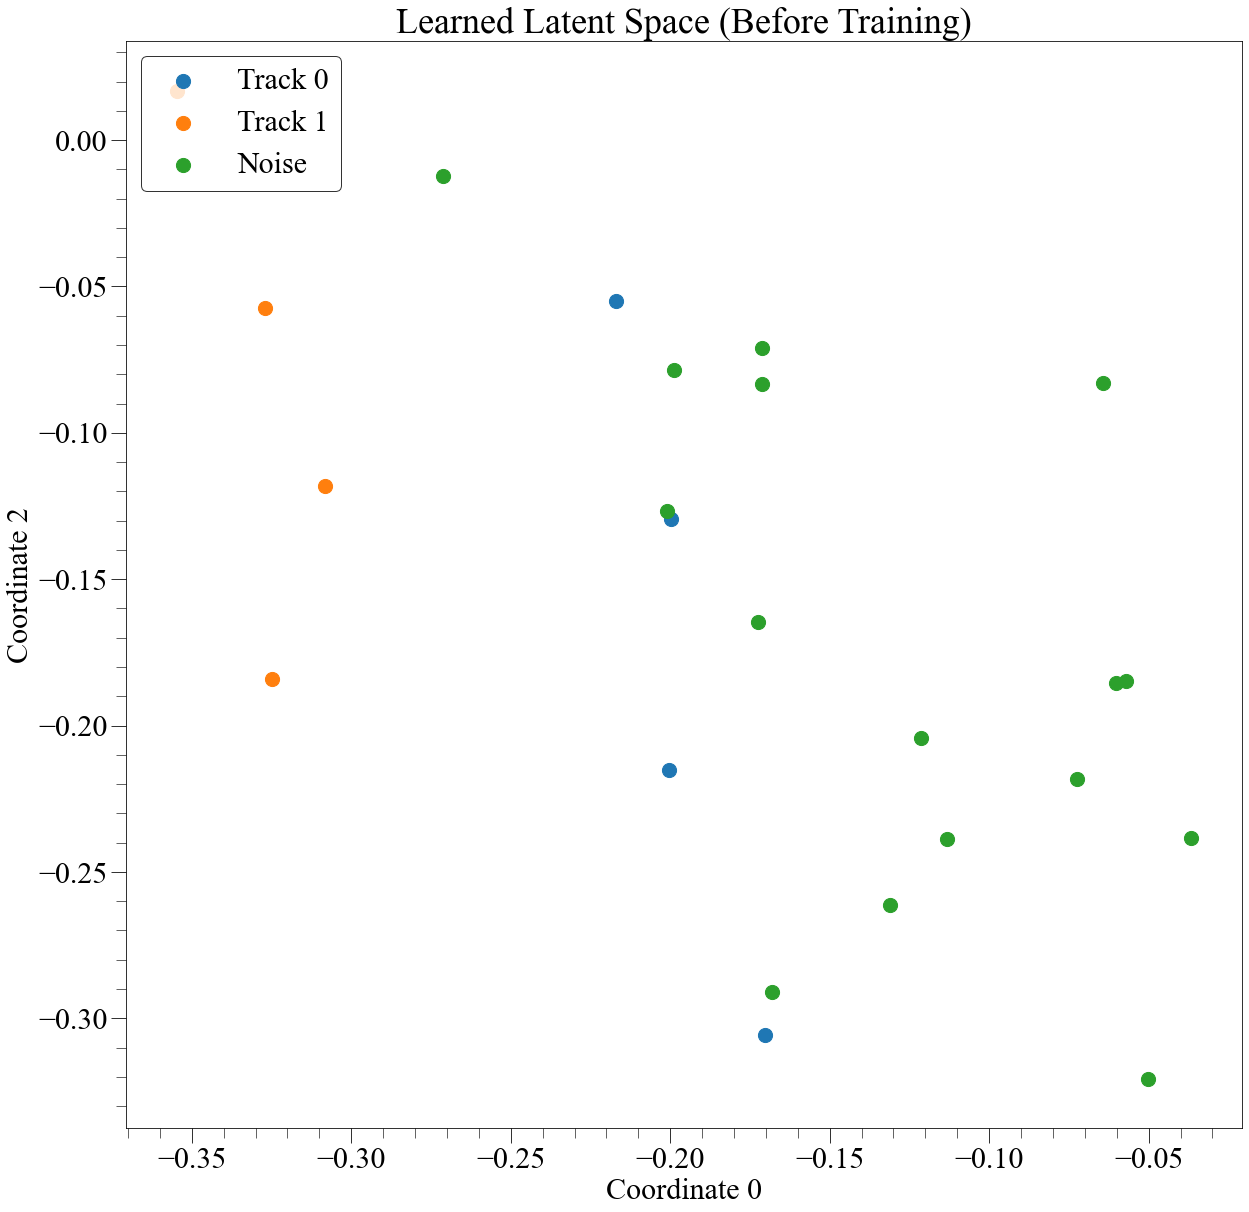

Train on 13334 samples, validate on 6666 samples
Epoch 1/10
13334/13334 [==============================] - 15s 1ms/sample - loss: 0.3850 - val_loss: 0.3266
Epoch 2/10
13334/13334 [==============================] - 9s 664us/sample - loss: 0.3139 - val_loss: 0.3111
Epoch 3/10
13334/13334 [==============================] - 9s 659us/sample - loss: 0.3047 - val_loss: 0.3021
Epoch 4/10
13334/13334 [==============================] - 9s 665us/sample - loss: 0.2992 - val_loss: 0.2955
Epoch 5/10
13334/13334 [==============================] - 9s 685us/sample - loss: 0.2925 - val_loss: 0.2952
Epoch 6/10
13334/13334 [==============================] - 9s 678us/sample - loss: 0.2894 - val_loss: 0.2862
Epoch 7/10
13334/13334 [==============================] - 9s 677us/sample - loss: 0.2851 - val_loss: 0.2901
Epoch 8/10
13334/13334 [==============================] - 9s 678us/sample - loss: 0.2831 - val_loss: 0.2868
Epoch 9/10
13334/13334 [==============================] - 9s 678us/sample - loss: 0.2794

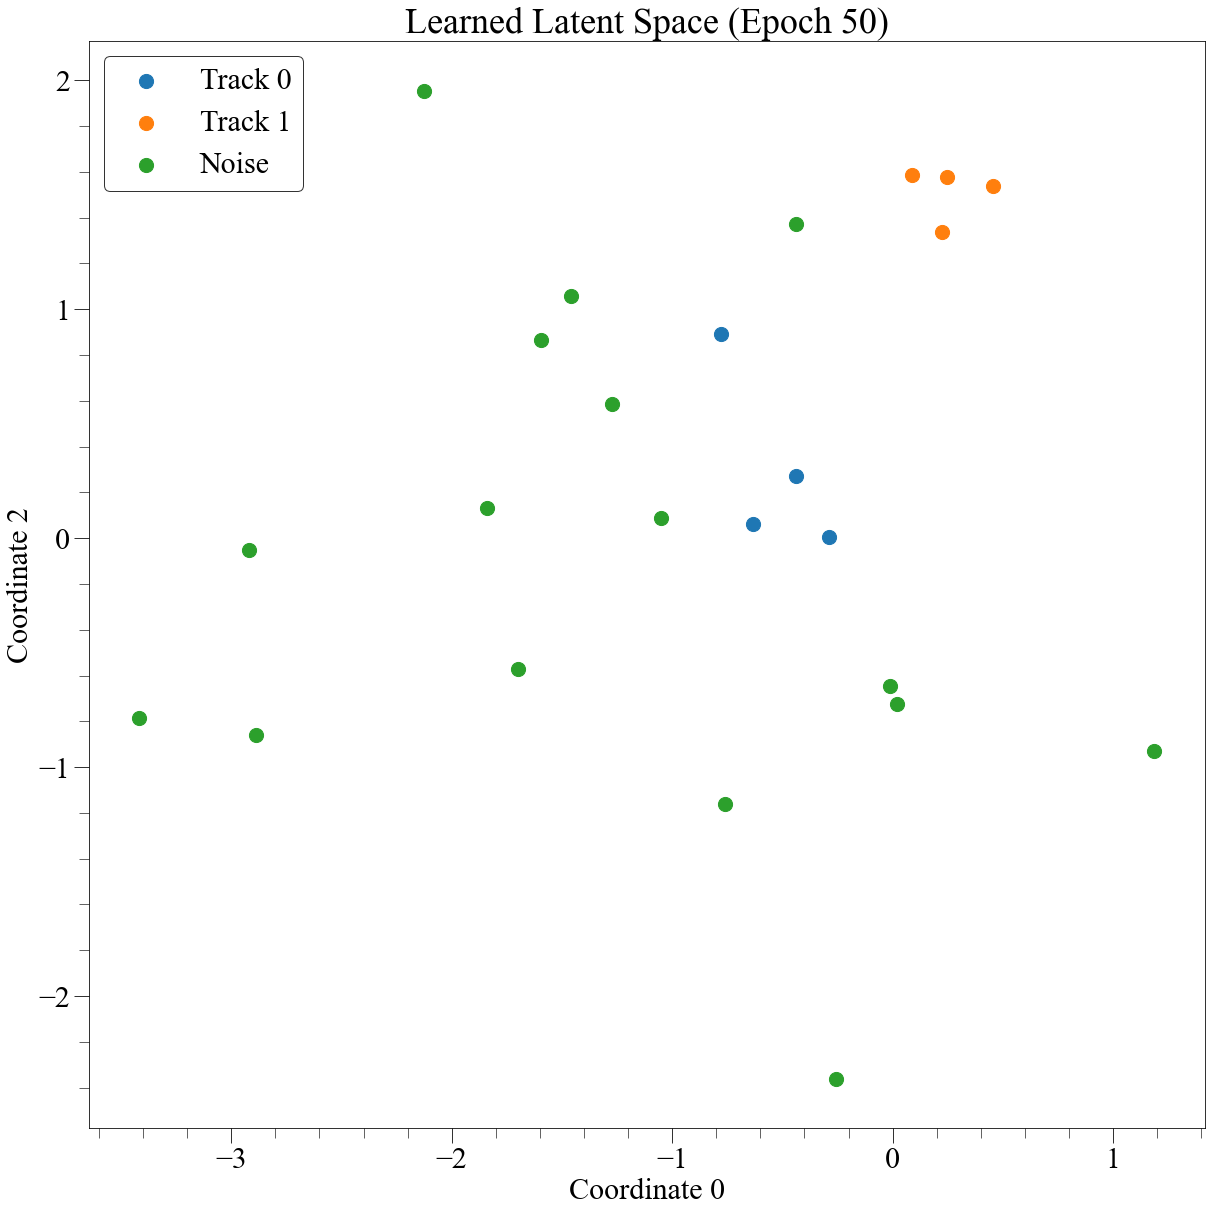

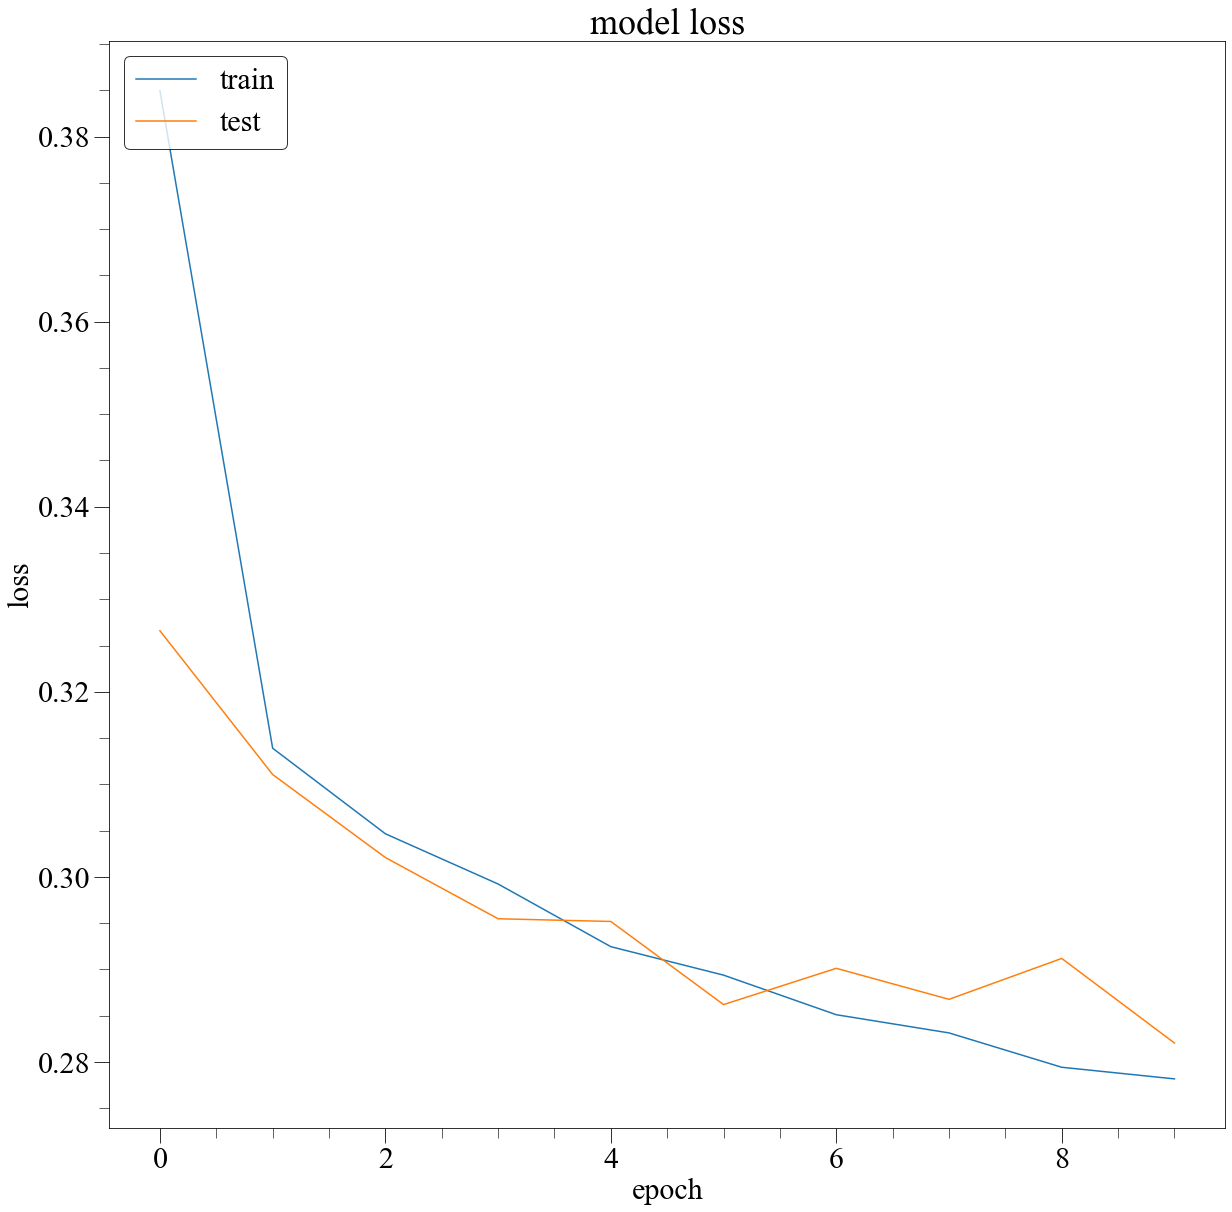

Train on 13334 samples, validate on 6666 samples
Epoch 1/10
13334/13334 [==============================] - 10s 716us/sample - loss: 0.2768 - val_loss: 0.2768
Epoch 2/10
13334/13334 [==============================] - 9s 704us/sample - loss: 0.2753 - val_loss: 0.2745
Epoch 3/10
13334/13334 [==============================] - 10s 756us/sample - loss: 0.2734 - val_loss: 0.2761
Epoch 4/10
13334/13334 [==============================] - 10s 758us/sample - loss: 0.2730 - val_loss: 0.2713
Epoch 5/10
13334/13334 [==============================] - 9s 706us/sample - loss: 0.2708 - val_loss: 0.2771
Epoch 6/10
13334/13334 [==============================] - 10s 715us/sample - loss: 0.2720 - val_loss: 0.2699
Epoch 7/10
13334/13334 [==============================] - 9s 685us/sample - loss: 0.2712 - val_loss: 0.2773
Epoch 8/10
13334/13334 [==============================] - 9s 663us/sample - loss: 0.2696 - val_loss: 0.2766
Epoch 9/10
13334/13334 [==============================] - 9s 667us/sample - loss: 0

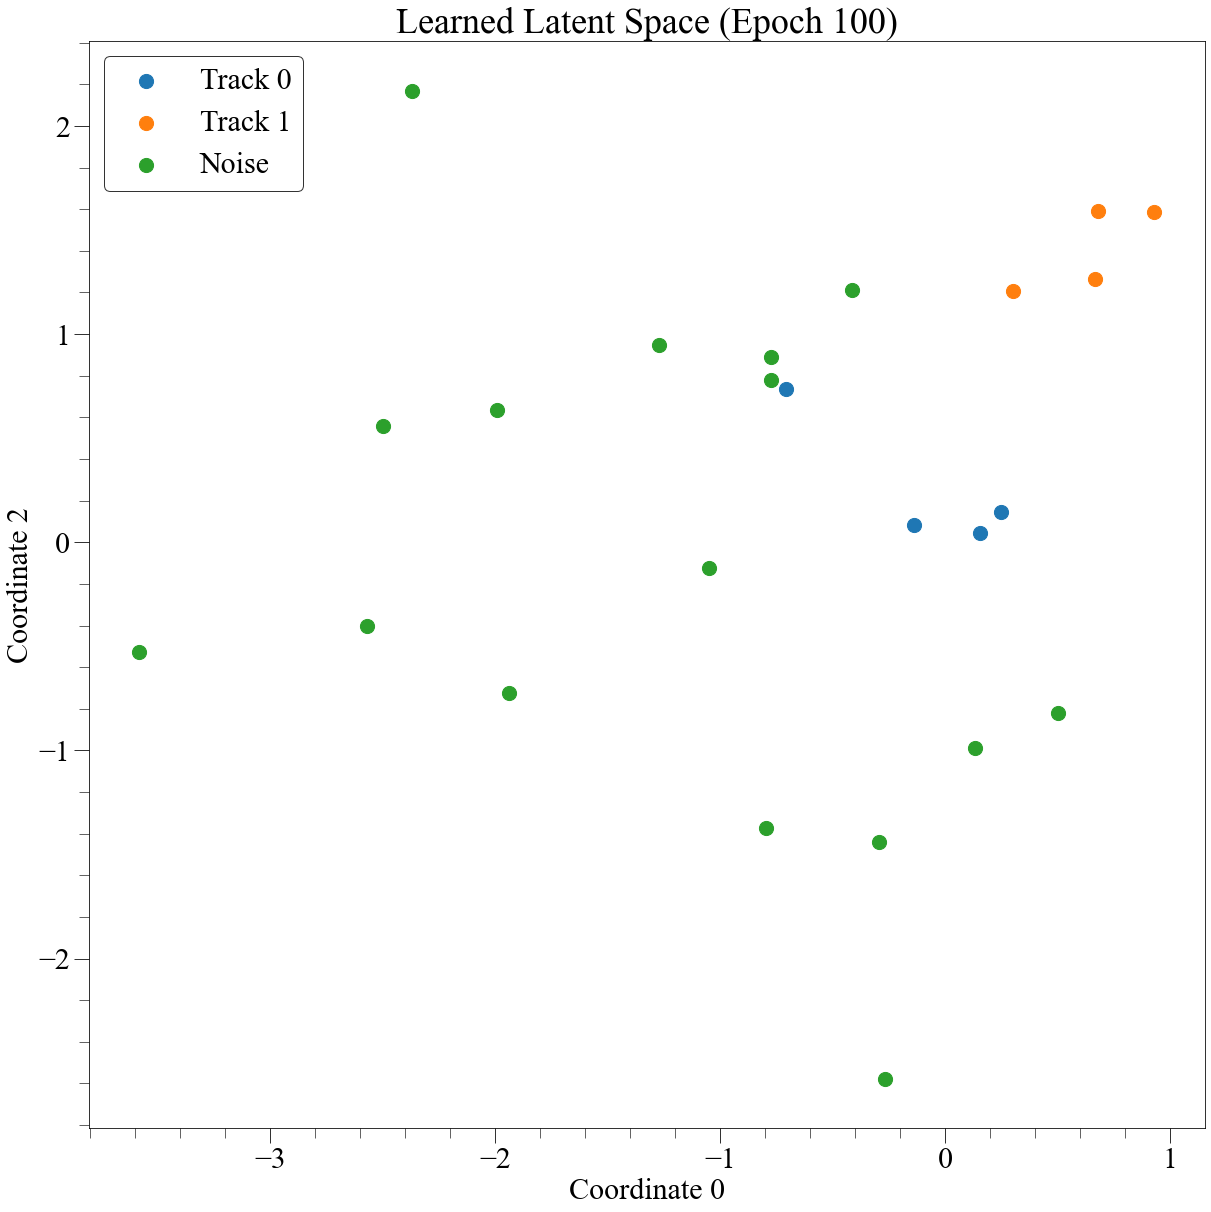

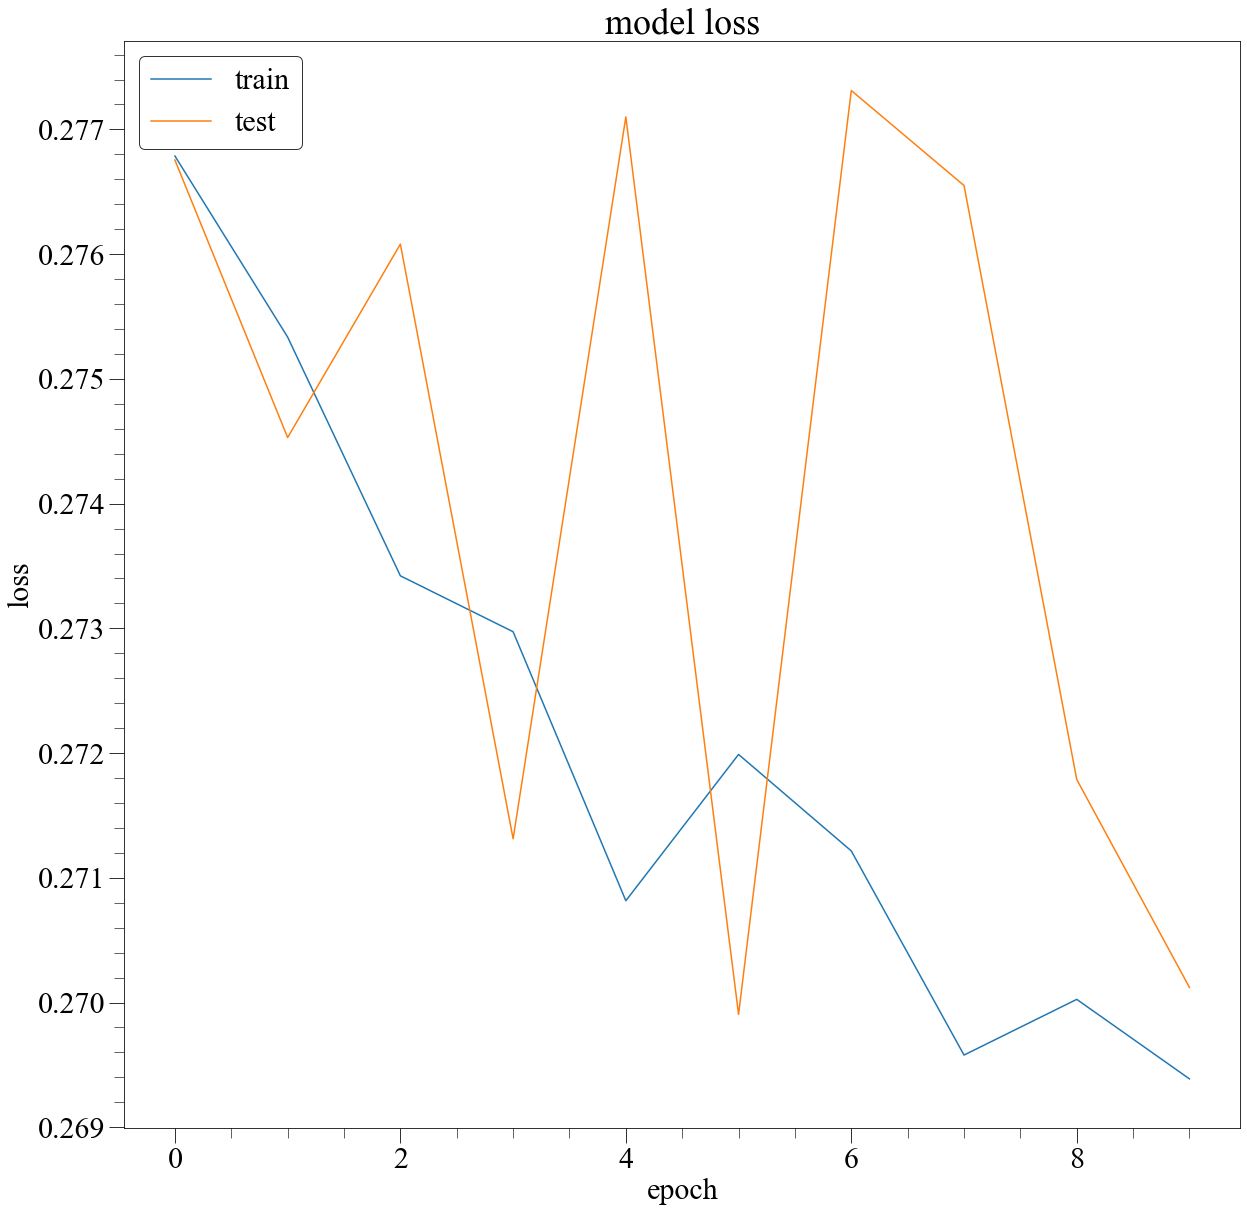

Train on 13334 samples, validate on 6666 samples
Epoch 1/10
13334/13334 [==============================] - 9s 668us/sample - loss: 0.2694 - val_loss: 0.2830
Epoch 2/10
13334/13334 [==============================] - 9s 666us/sample - loss: 0.2694 - val_loss: 0.2685
Epoch 3/10
13334/13334 [==============================] - 9s 667us/sample - loss: 0.2676 - val_loss: 0.2680
Epoch 4/10
13334/13334 [==============================] - 9s 664us/sample - loss: 0.2669 - val_loss: 0.2686
Epoch 5/10
13334/13334 [==============================] - 9s 667us/sample - loss: 0.2676 - val_loss: 0.2681
Epoch 6/10
13334/13334 [==============================] - 9s 665us/sample - loss: 0.2672 - val_loss: 0.2640
Epoch 7/10
13334/13334 [==============================] - 9s 676us/sample - loss: 0.2654 - val_loss: 0.2679
Epoch 8/10
13334/13334 [==============================] - 9s 668us/sample - loss: 0.2650 - val_loss: 0.2688
Epoch 9/10
13334/13334 [==============================] - 9s 670us/sample - loss: 0.266

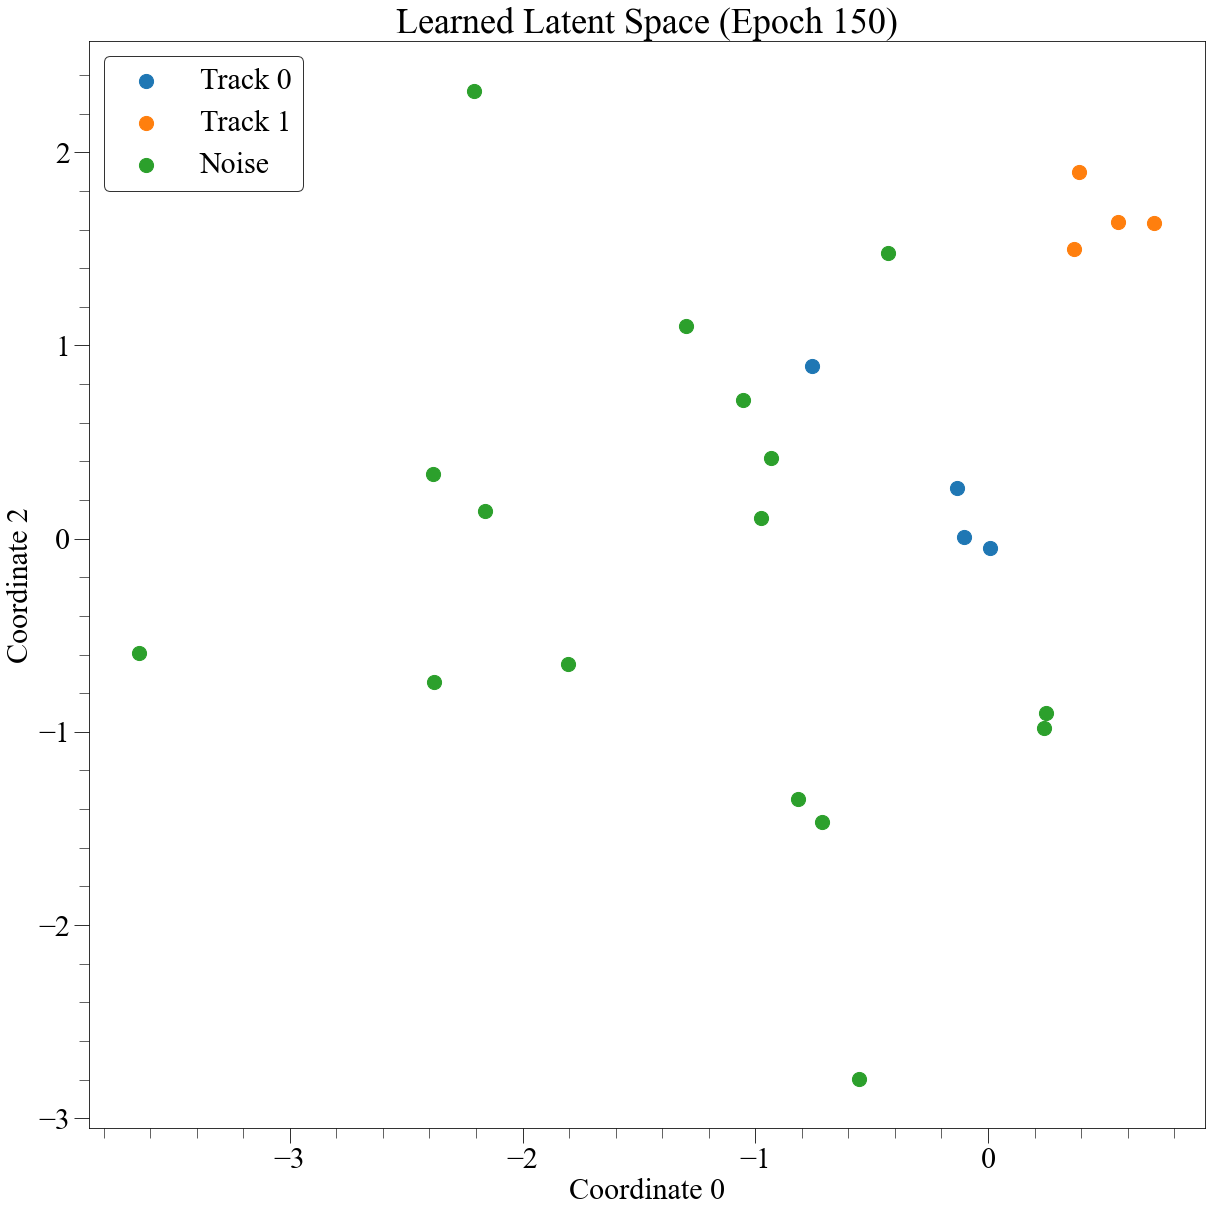

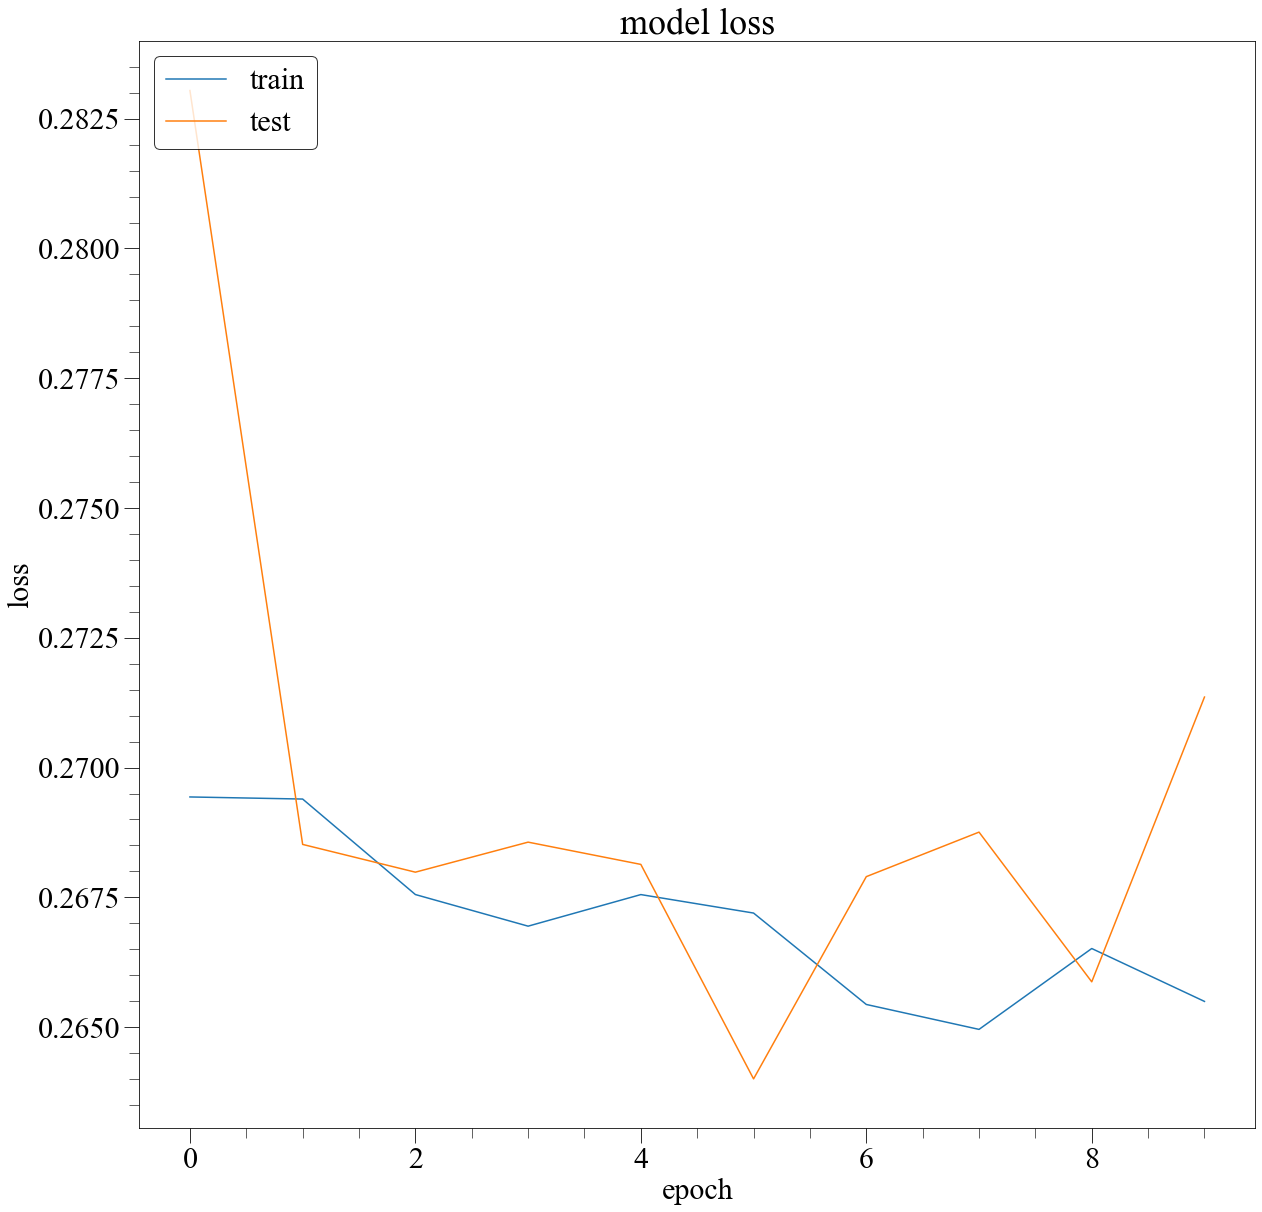

Train on 13334 samples, validate on 6666 samples
Epoch 1/10
13334/13334 [==============================] - 9s 673us/sample - loss: 0.2640 - val_loss: 0.2718
Epoch 2/10
13334/13334 [==============================] - 9s 669us/sample - loss: 0.2649 - val_loss: 0.2688
Epoch 3/10
13334/13334 [==============================] - 9s 669us/sample - loss: 0.2640 - val_loss: 0.2652
Epoch 4/10
13334/13334 [==============================] - 9s 673us/sample - loss: 0.2652 - val_loss: 0.2663
Epoch 5/10
13334/13334 [==============================] - 9s 670us/sample - loss: 0.2635 - val_loss: 0.2633
Epoch 6/10
13334/13334 [==============================] - 9s 670us/sample - loss: 0.2628 - val_loss: 0.2689
Epoch 7/10
13334/13334 [==============================] - 9s 672us/sample - loss: 0.2649 - val_loss: 0.2688
Epoch 8/10
13334/13334 [==============================] - 9s 678us/sample - loss: 0.2629 - val_loss: 0.2663
Epoch 9/10
13334/13334 [==============================] - 9s 670us/sample - loss: 0.262

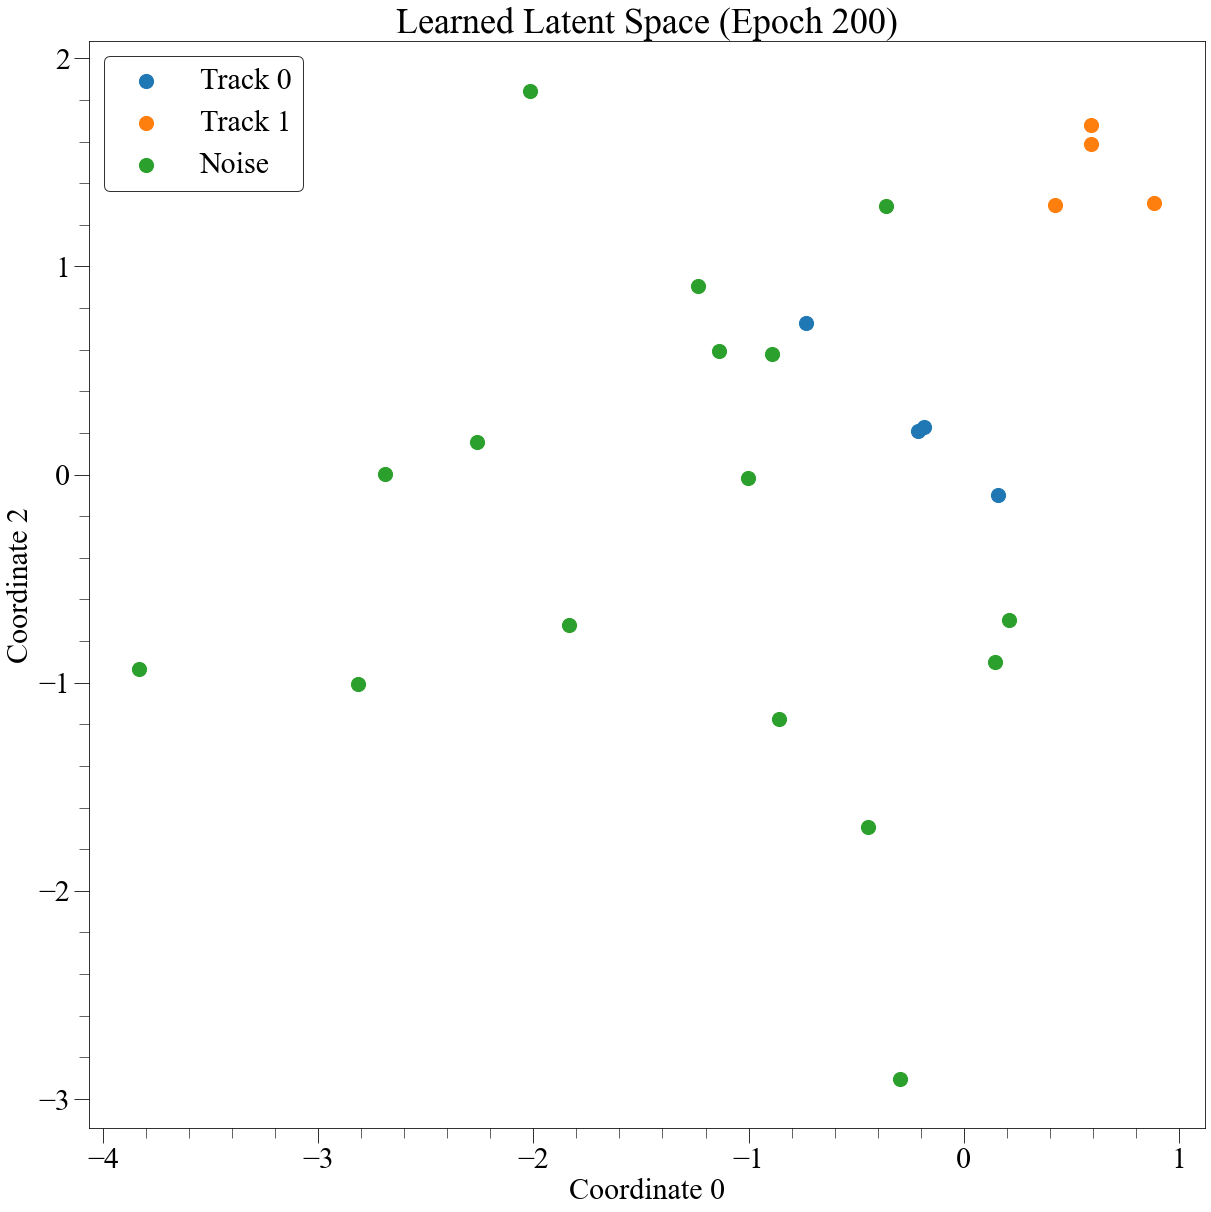

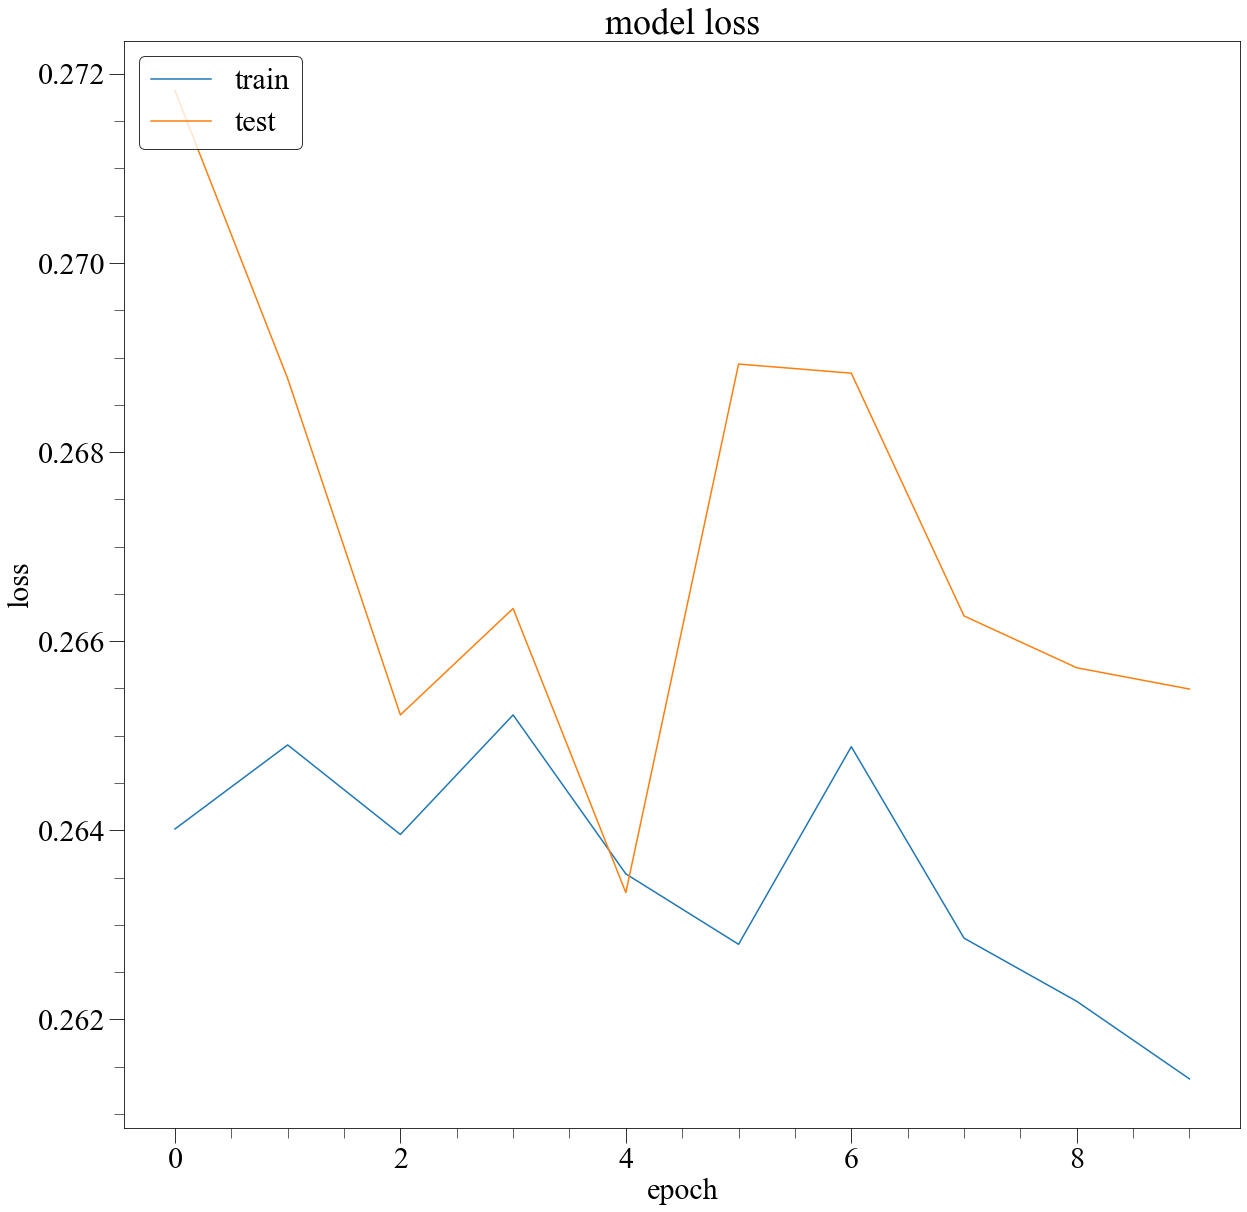

Train on 13334 samples, validate on 6666 samples
Epoch 1/10
13334/13334 [==============================] - 9s 666us/sample - loss: 0.2631 - val_loss: 0.2665
Epoch 2/10
13334/13334 [==============================] - 9s 665us/sample - loss: 0.2617 - val_loss: 0.2643
Epoch 3/10
13334/13334 [==============================] - 10s 712us/sample - loss: 0.2622 - val_loss: 0.2631
Epoch 4/10
13334/13334 [==============================] - 10s 740us/sample - loss: 0.2621 - val_loss: 0.2633
Epoch 5/10
13334/13334 [==============================] - 10s 734us/sample - loss: 0.2619 - val_loss: 0.2644
Epoch 6/10
13334/13334 [==============================] - 10s 736us/sample - loss: 0.2618 - val_loss: 0.2655
Epoch 7/10
13334/13334 [==============================] - 10s 714us/sample - loss: 0.2602 - val_loss: 0.2662
Epoch 8/10
13334/13334 [==============================] - 9s 696us/sample - loss: 0.2611 - val_loss: 0.2660
Epoch 9/10
13334/13334 [==============================] - 10s 724us/sample - loss:

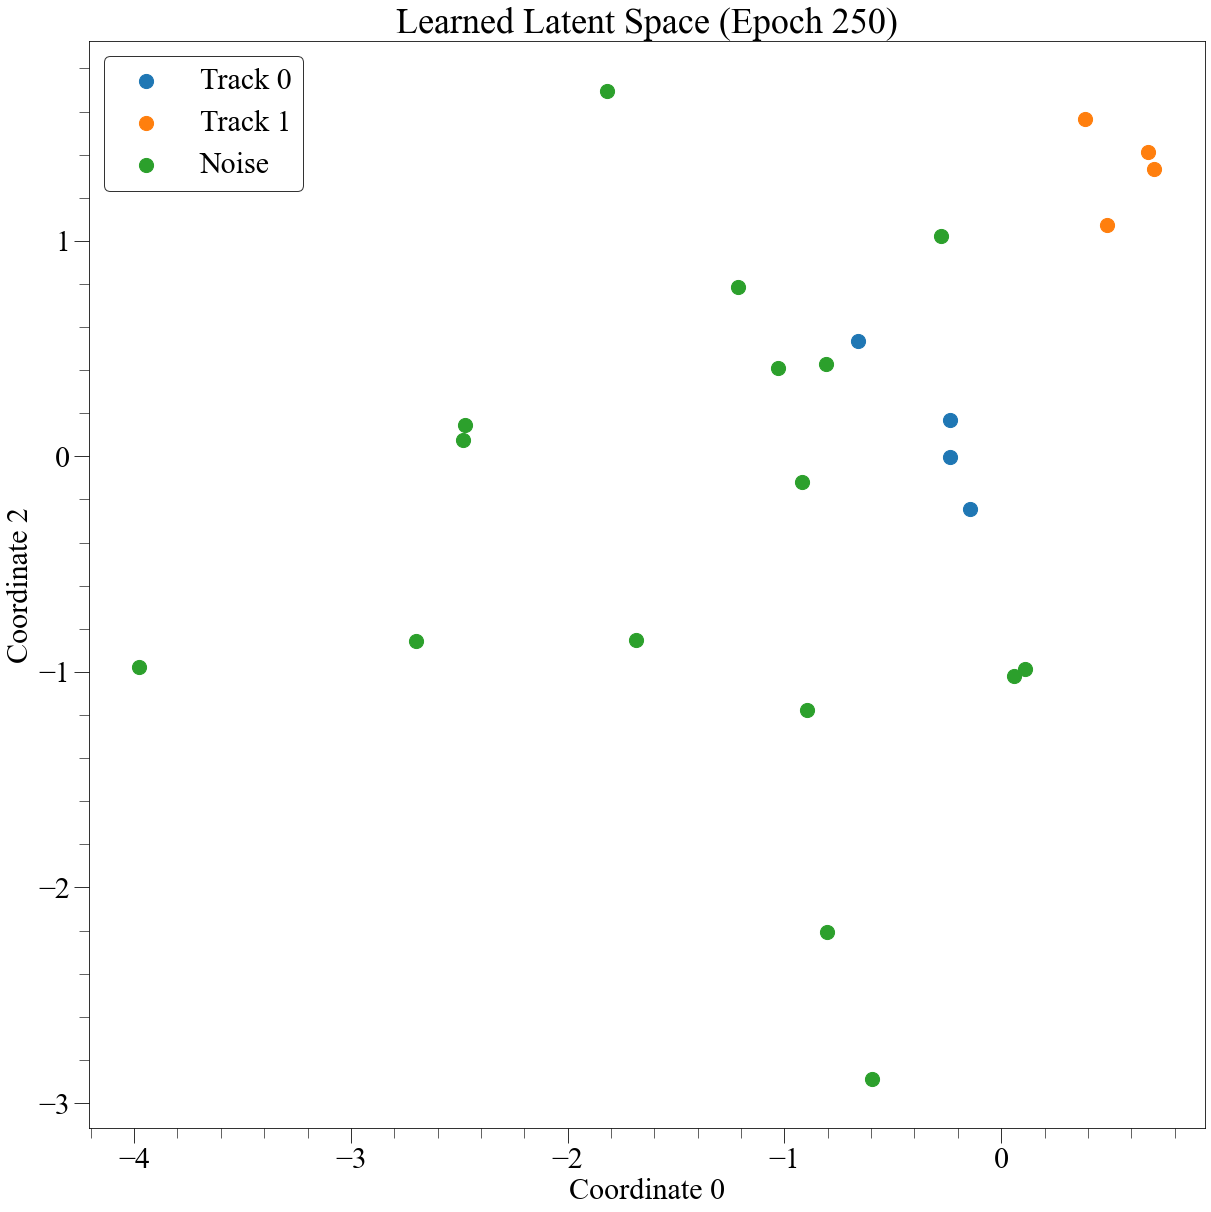

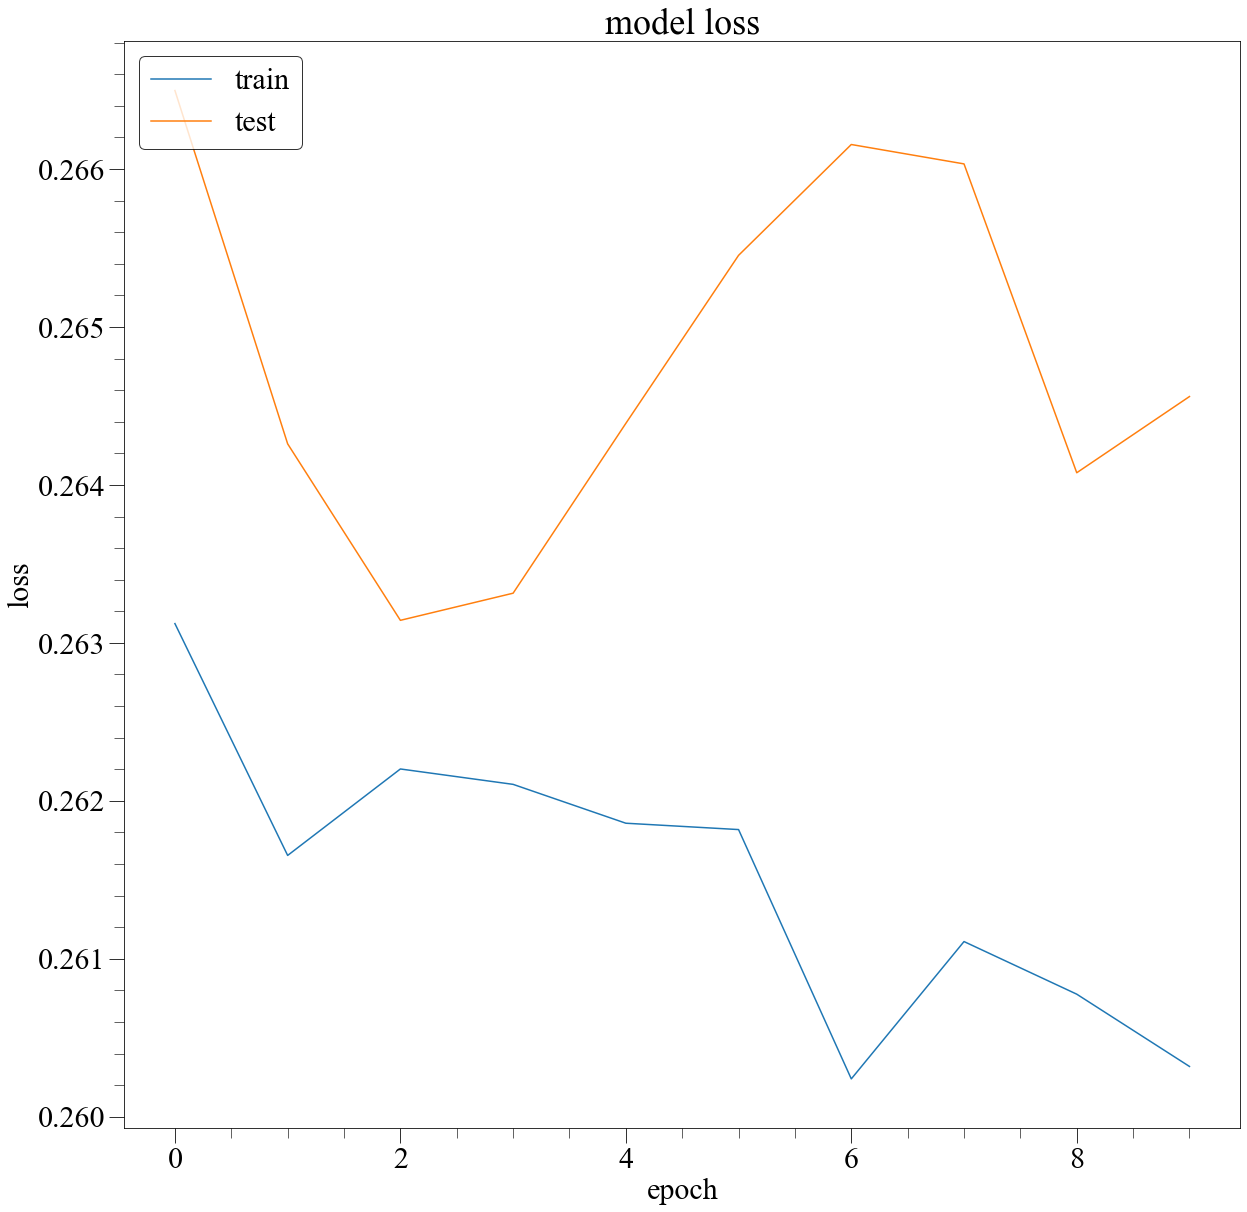

Train on 13334 samples, validate on 6666 samples
Epoch 1/10
13334/13334 [==============================] - 10s 732us/sample - loss: 0.2612 - val_loss: 0.2665
Epoch 2/10
13334/13334 [==============================] - 9s 712us/sample - loss: 0.2604 - val_loss: 0.2661
Epoch 3/10
13334/13334 [==============================] - 9s 685us/sample - loss: 0.2606 - val_loss: 0.2620
Epoch 4/10
13334/13334 [==============================] - 10s 724us/sample - loss: 0.2611 - val_loss: 0.2629
Epoch 5/10
13334/13334 [==============================] - 10s 726us/sample - loss: 0.2602 - val_loss: 0.2645
Epoch 6/10
13334/13334 [==============================] - 10s 717us/sample - loss: 0.2589 - val_loss: 0.2648
Epoch 7/10
13334/13334 [==============================] - 10s 737us/sample - loss: 0.2597 - val_loss: 0.2644
Epoch 8/10
13334/13334 [==============================] - 10s 745us/sample - loss: 0.2599 - val_loss: 0.2675
Epoch 9/10
13334/13334 [==============================] - 10s 735us/sample - loss

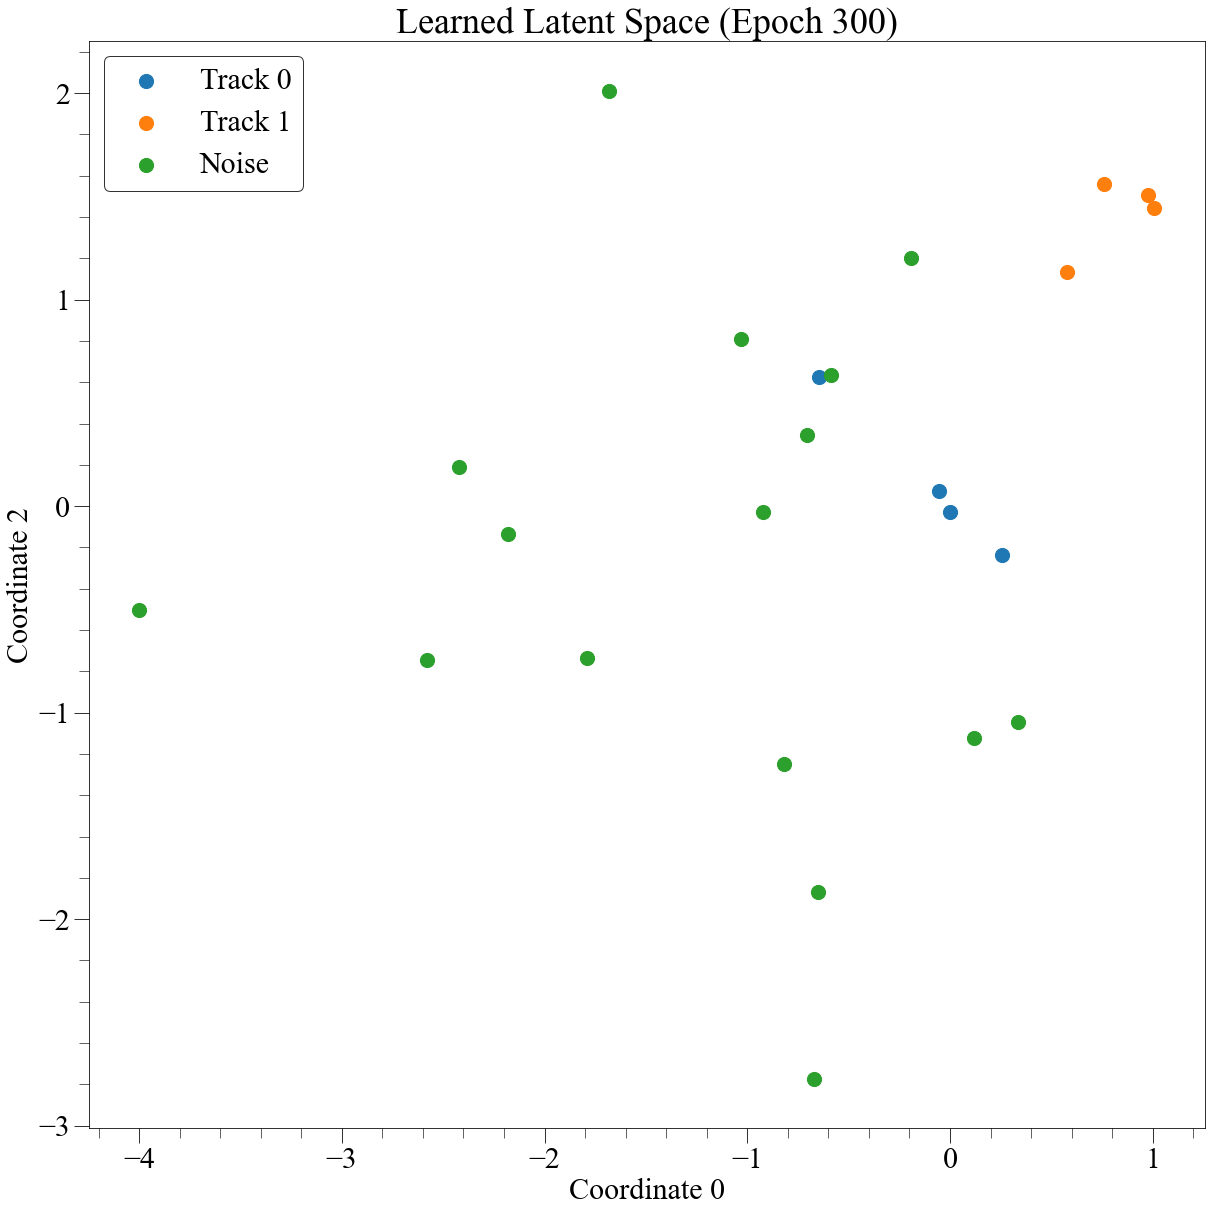

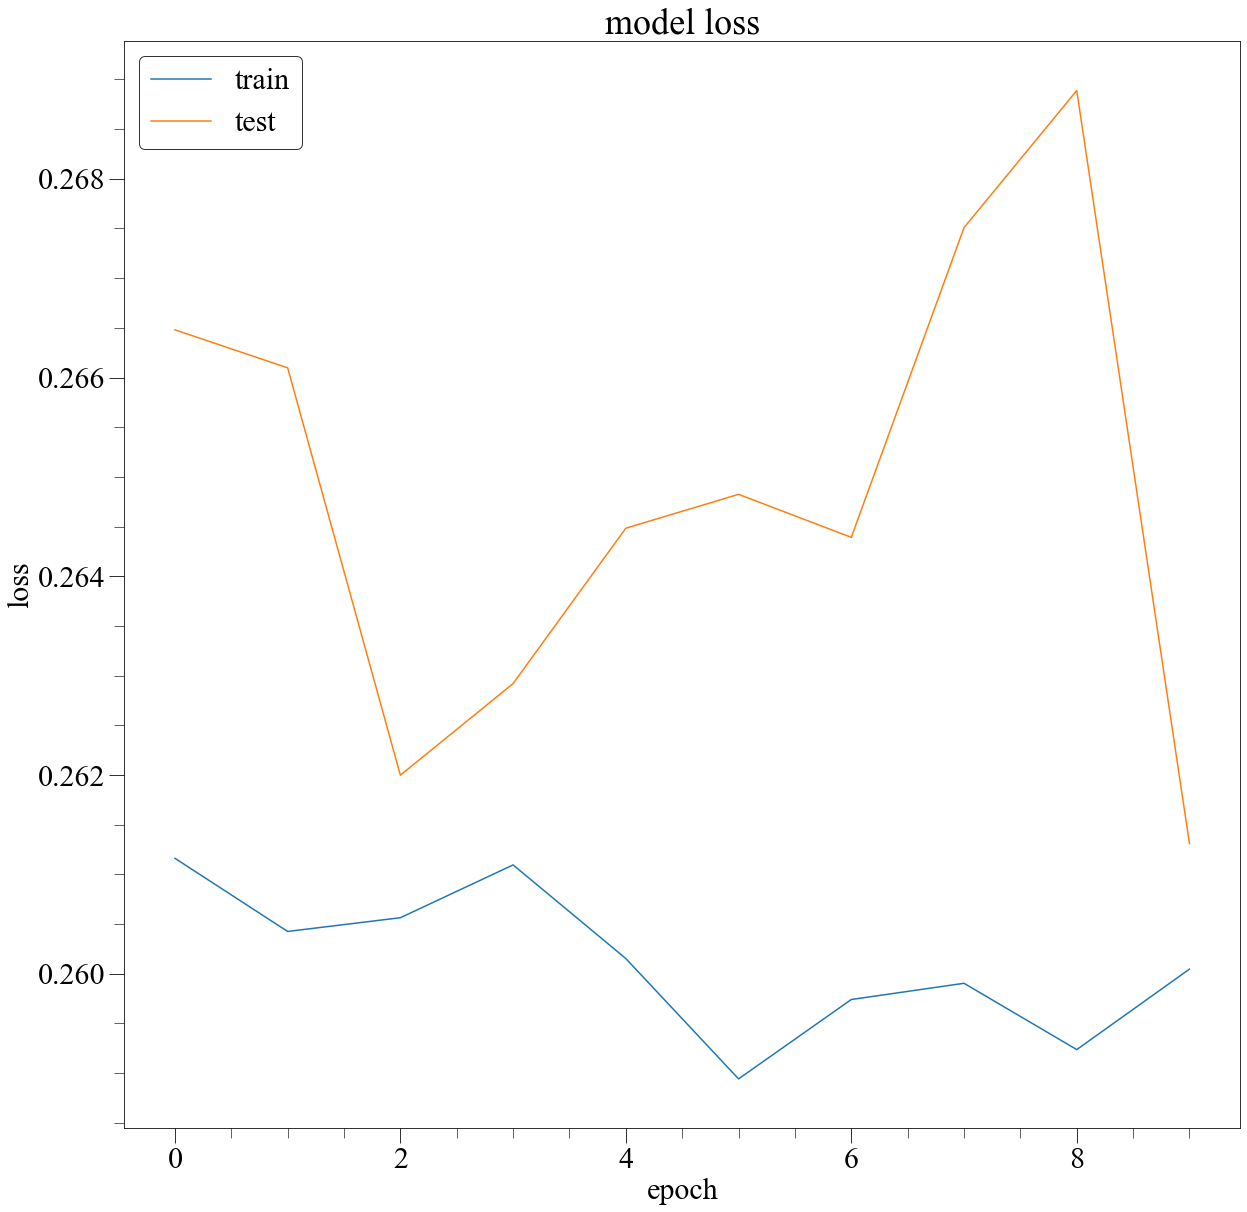

Train on 13334 samples, validate on 6666 samples
Epoch 1/10
13334/13334 [==============================] - 10s 717us/sample - loss: 0.2590 - val_loss: 0.2634
Epoch 2/10
13334/13334 [==============================] - 10s 715us/sample - loss: 0.2593 - val_loss: 0.2628
Epoch 3/10
13334/13334 [==============================] - 10s 737us/sample - loss: 0.2586 - val_loss: 0.2638
Epoch 4/10
13334/13334 [==============================] - 10s 764us/sample - loss: 0.2576 - val_loss: 0.2616
Epoch 5/10
13334/13334 [==============================] - 10s 783us/sample - loss: 0.2576 - val_loss: 0.2657
Epoch 6/10
13334/13334 [==============================] - 10s 754us/sample - loss: 0.2588 - val_loss: 0.2617
Epoch 7/10
13334/13334 [==============================] - 10s 738us/sample - loss: 0.2578 - val_loss: 0.2639
Epoch 8/10
13334/13334 [==============================] - 10s 759us/sample - loss: 0.2569 - val_loss: 0.2627
Epoch 9/10
13334/13334 [==============================] - 10s 786us/sample - lo

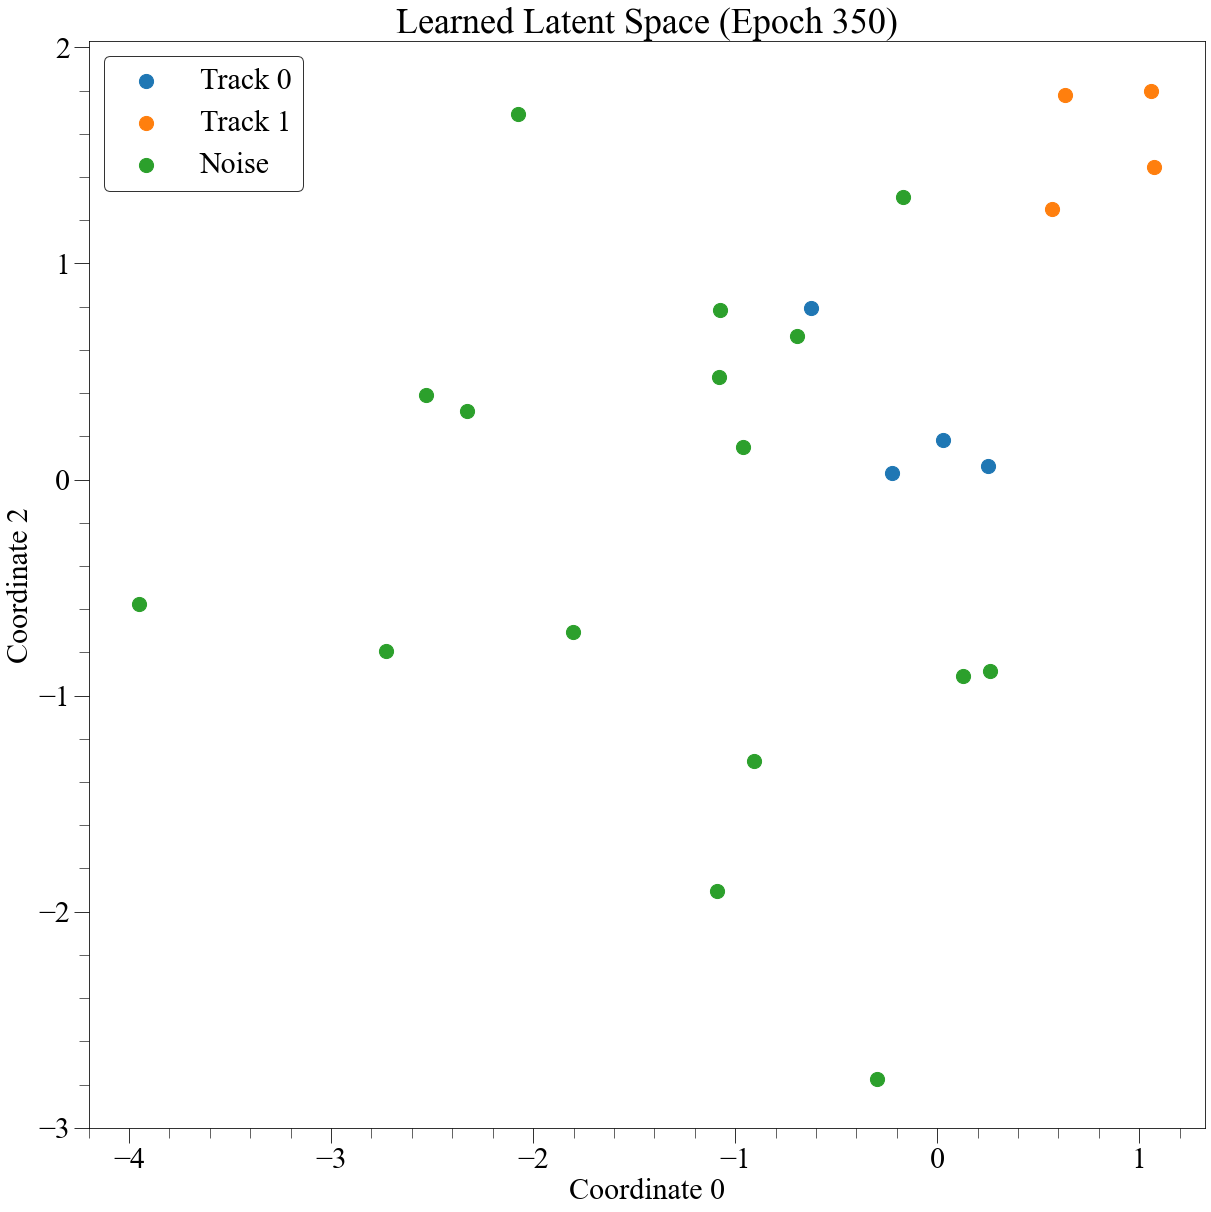

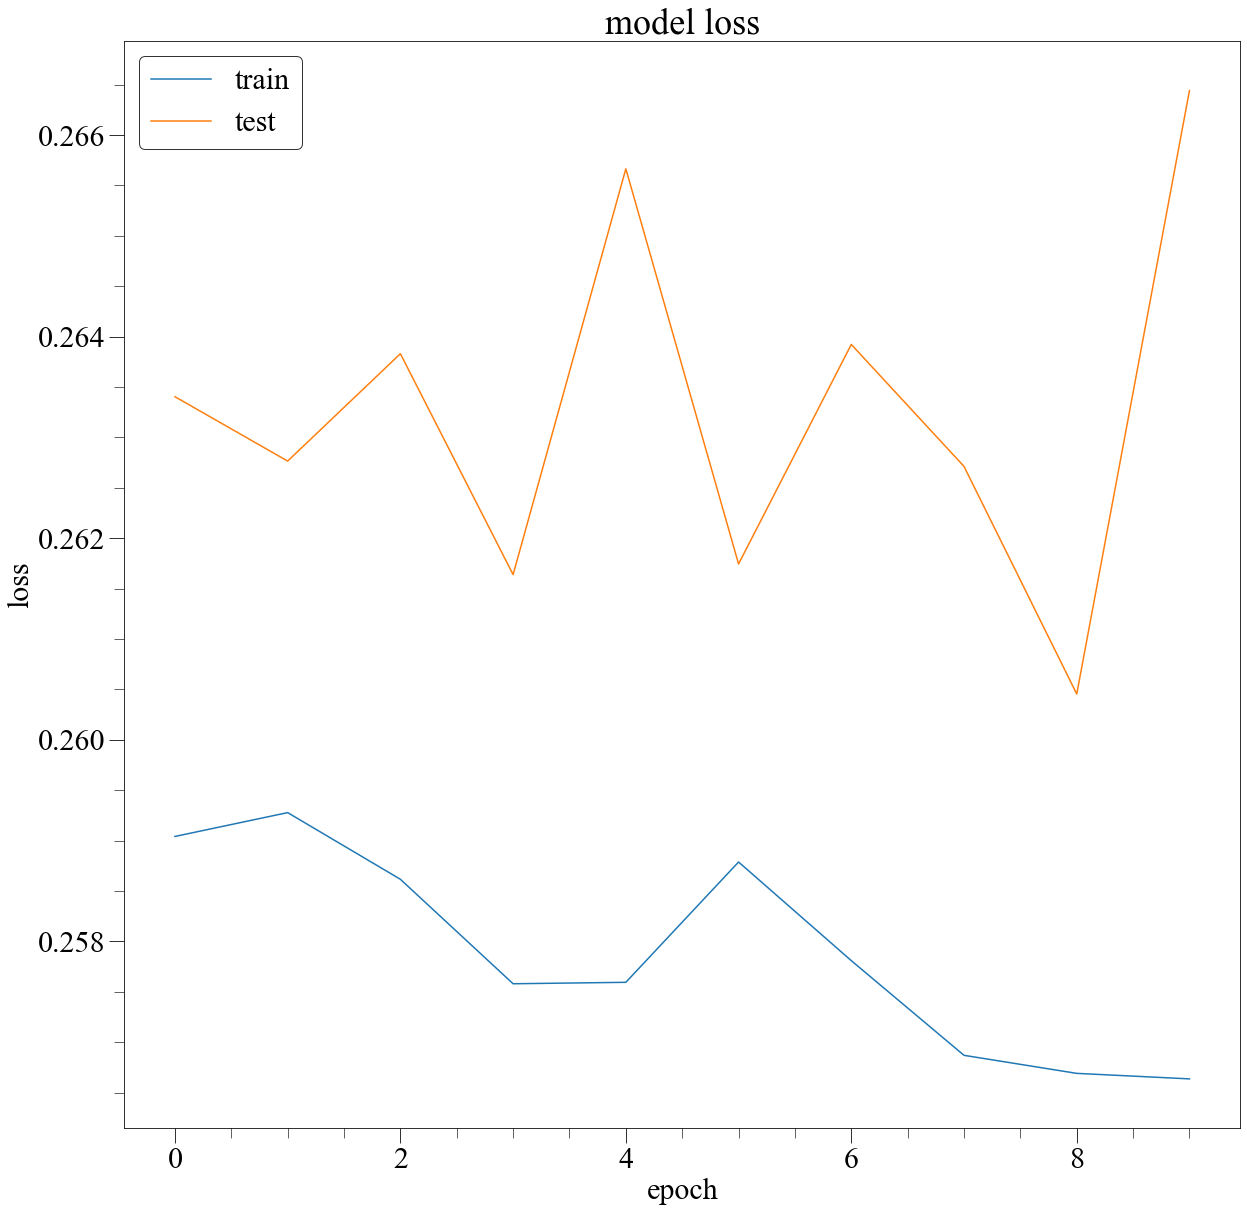

Train on 13334 samples, validate on 6666 samples
Epoch 1/10
13334/13334 [==============================] - 11s 799us/sample - loss: 0.2576 - val_loss: 0.2630
Epoch 2/10
13334/13334 [==============================] - 10s 731us/sample - loss: 0.2567 - val_loss: 0.2611
Epoch 3/10
13334/13334 [==============================] - 10s 721us/sample - loss: 0.2555 - val_loss: 0.2618
Epoch 4/10
13334/13334 [==============================] - 10s 736us/sample - loss: 0.2569 - val_loss: 0.2610
Epoch 5/10
13334/13334 [==============================] - 10s 742us/sample - loss: 0.2563 - val_loss: 0.2634
Epoch 6/10
13334/13334 [==============================] - 9s 683us/sample - loss: 0.2573 - val_loss: 0.2610
Epoch 7/10
13334/13334 [==============================] - 9s 682us/sample - loss: 0.2564 - val_loss: 0.2634
Epoch 8/10
13334/13334 [==============================] - 9s 694us/sample - loss: 0.2560 - val_loss: 0.2616
Epoch 9/10
13334/13334 [==============================] - 10s 771us/sample - loss:

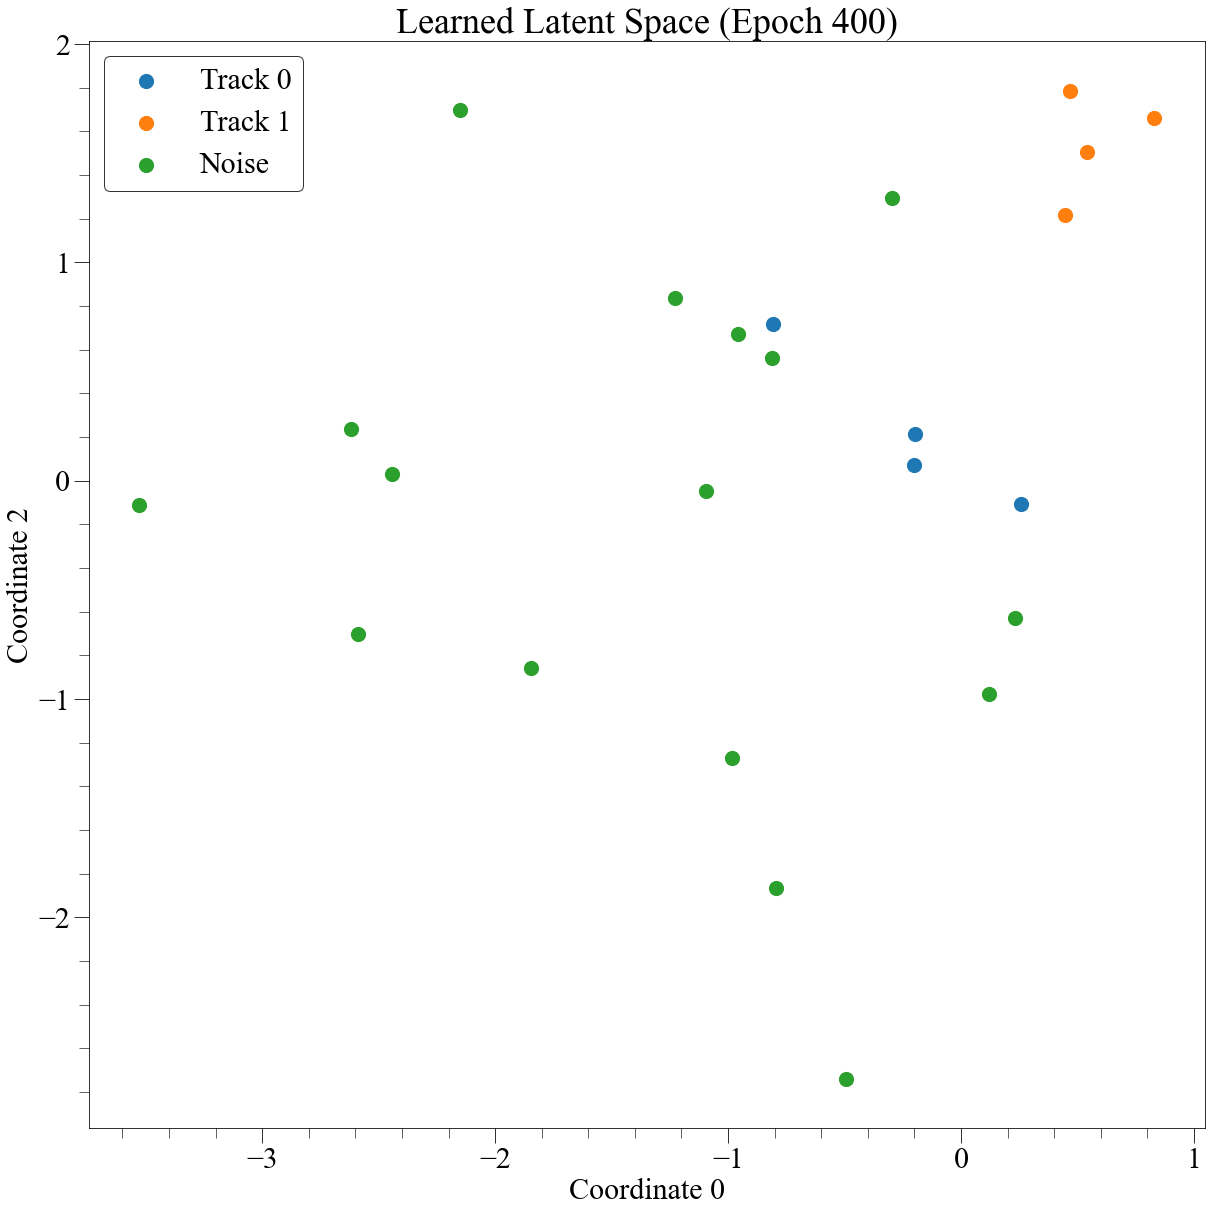

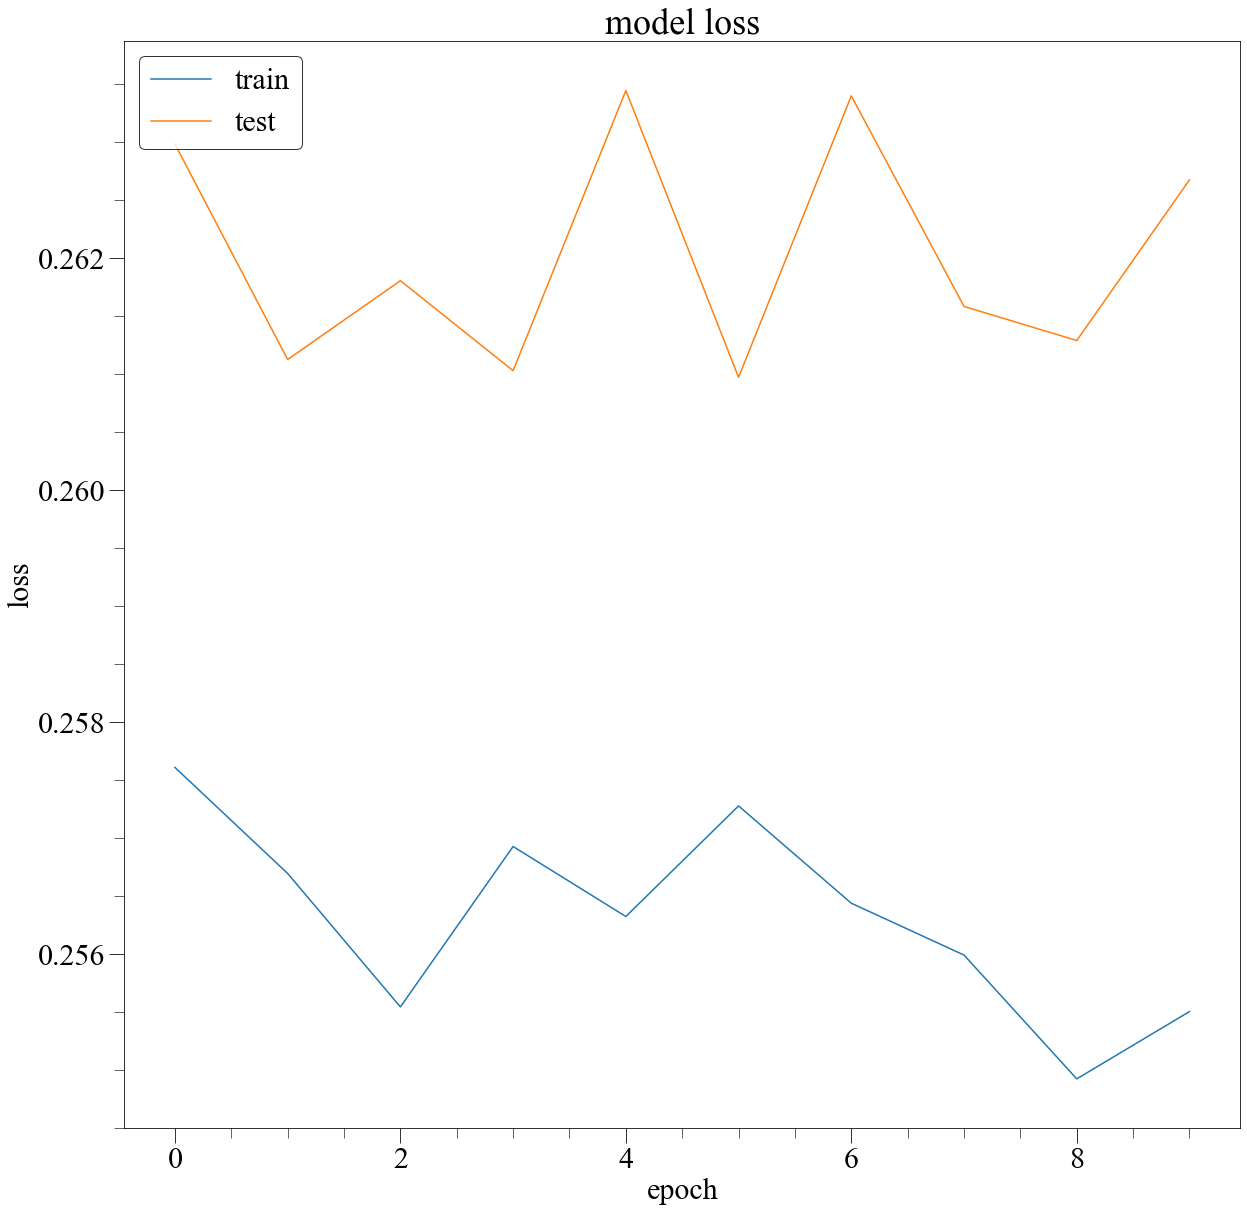

Train on 13334 samples, validate on 6666 samples
Epoch 1/10
13334/13334 [==============================] - 9s 667us/sample - loss: 0.2565 - val_loss: 0.2686
Epoch 2/10
13334/13334 [==============================] - 11s 796us/sample - loss: 0.2569 - val_loss: 0.2603
Epoch 3/10
13334/13334 [==============================] - 10s 763us/sample - loss: 0.2559 - val_loss: 0.2621
Epoch 4/10
13334/13334 [==============================] - 10s 762us/sample - loss: 0.2546 - val_loss: 0.2634
Epoch 5/10
13334/13334 [==============================] - 10s 782us/sample - loss: 0.2553 - val_loss: 0.2649
Epoch 6/10
13334/13334 [==============================] - 10s 756us/sample - loss: 0.2560 - val_loss: 0.2607
Epoch 7/10
13334/13334 [==============================] - 11s 795us/sample - loss: 0.2558 - val_loss: 0.2636
Epoch 8/10
13334/13334 [==============================] - 10s 770us/sample - loss: 0.2550 - val_loss: 0.2593
Epoch 9/10
13334/13334 [==============================] - 10s 722us/sample - los

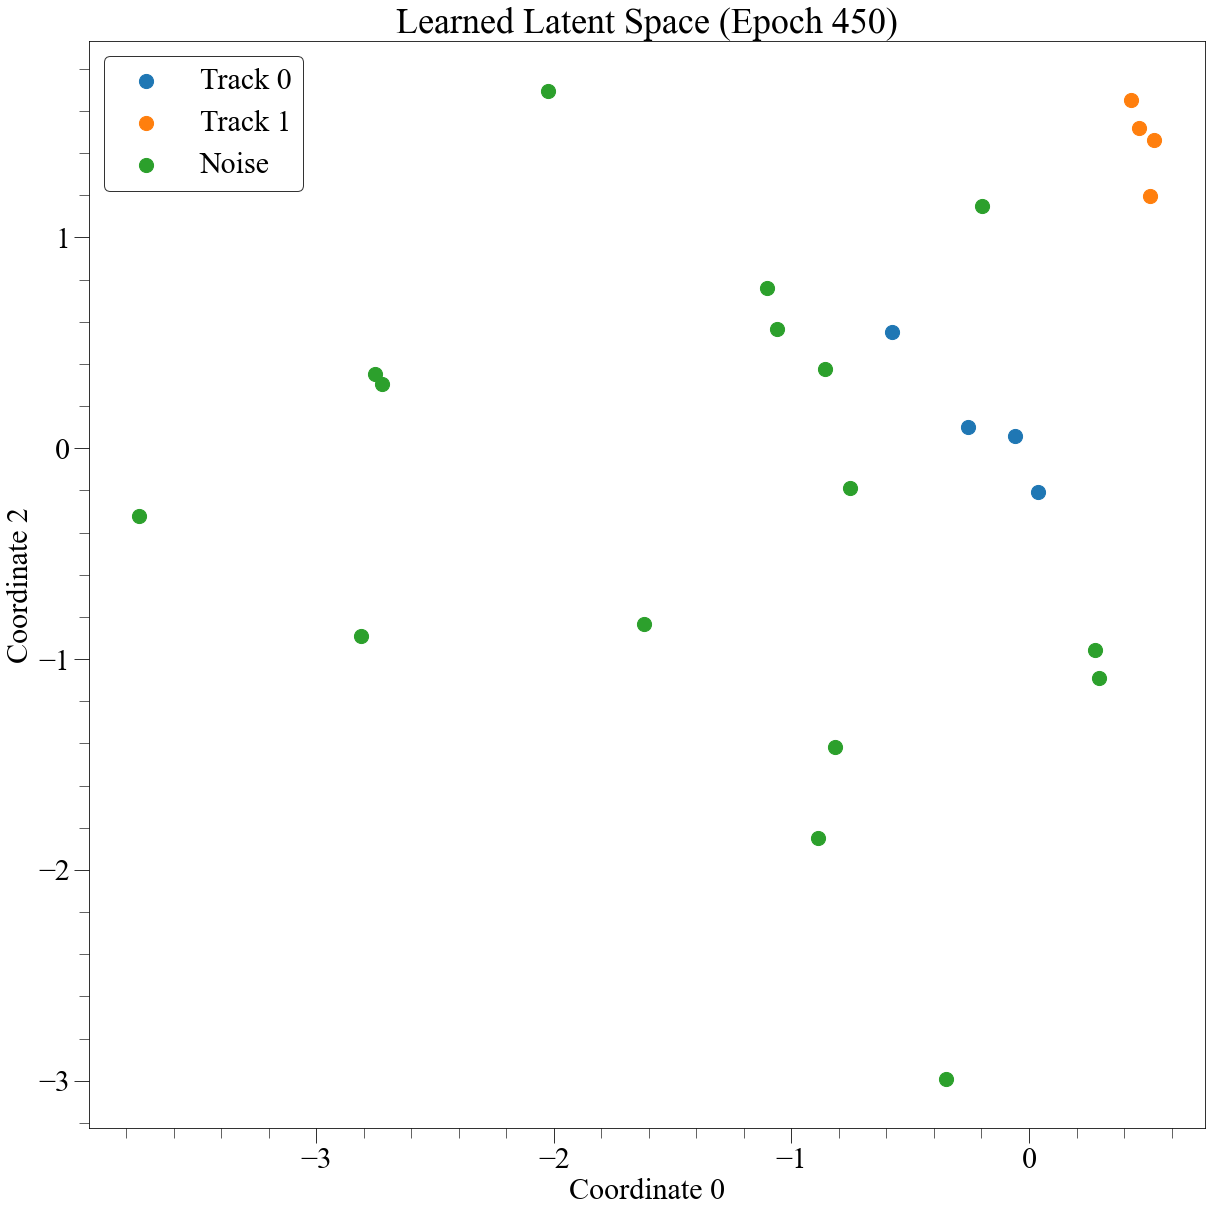

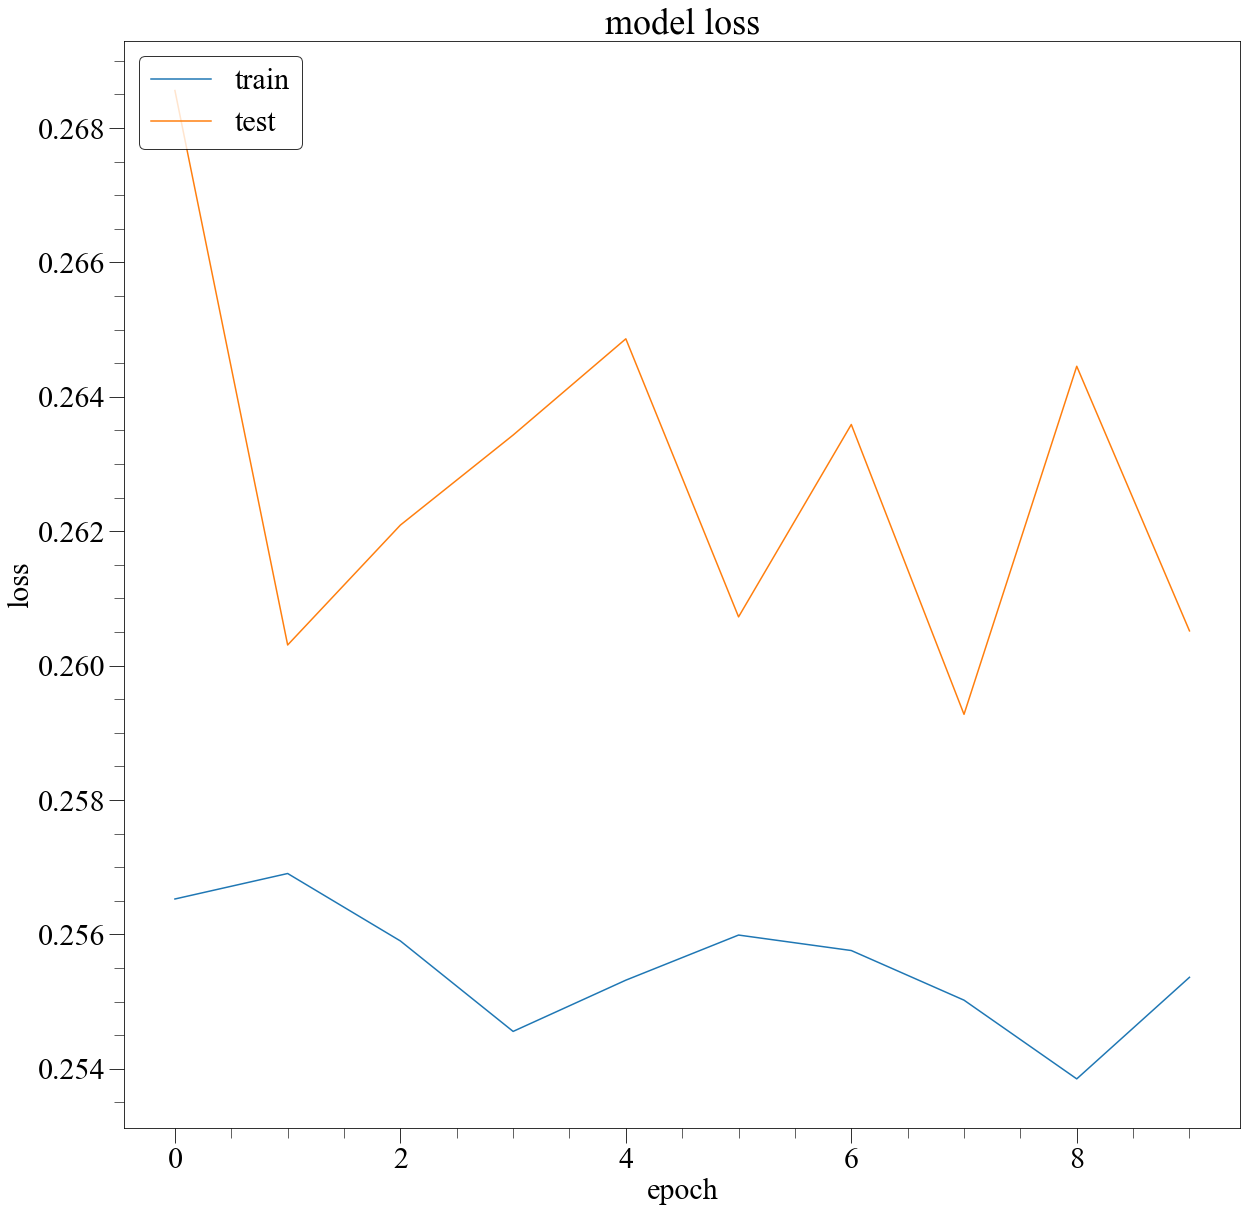

Train on 13334 samples, validate on 6666 samples
Epoch 1/10
13334/13334 [==============================] - 10s 730us/sample - loss: 0.2540 - val_loss: 0.2585
Epoch 2/10
13334/13334 [==============================] - 10s 745us/sample - loss: 0.2539 - val_loss: 0.2593
Epoch 3/10
13334/13334 [==============================] - 11s 793us/sample - loss: 0.2548 - val_loss: 0.2603
Epoch 4/10
13334/13334 [==============================] - 10s 728us/sample - loss: 0.2538 - val_loss: 0.2620
Epoch 5/10
13334/13334 [==============================] - 9s 673us/sample - loss: 0.2538 - val_loss: 0.2603
Epoch 6/10
13334/13334 [==============================] - 10s 713us/sample - loss: 0.2541 - val_loss: 0.2598
Epoch 7/10
13334/13334 [==============================] - 9s 701us/sample - loss: 0.2534 - val_loss: 0.2585
Epoch 8/10
13334/13334 [==============================] - 9s 669us/sample - loss: 0.2525 - val_loss: 0.2622
Epoch 9/10
13334/13334 [==============================] - 9s 710us/sample - loss: 

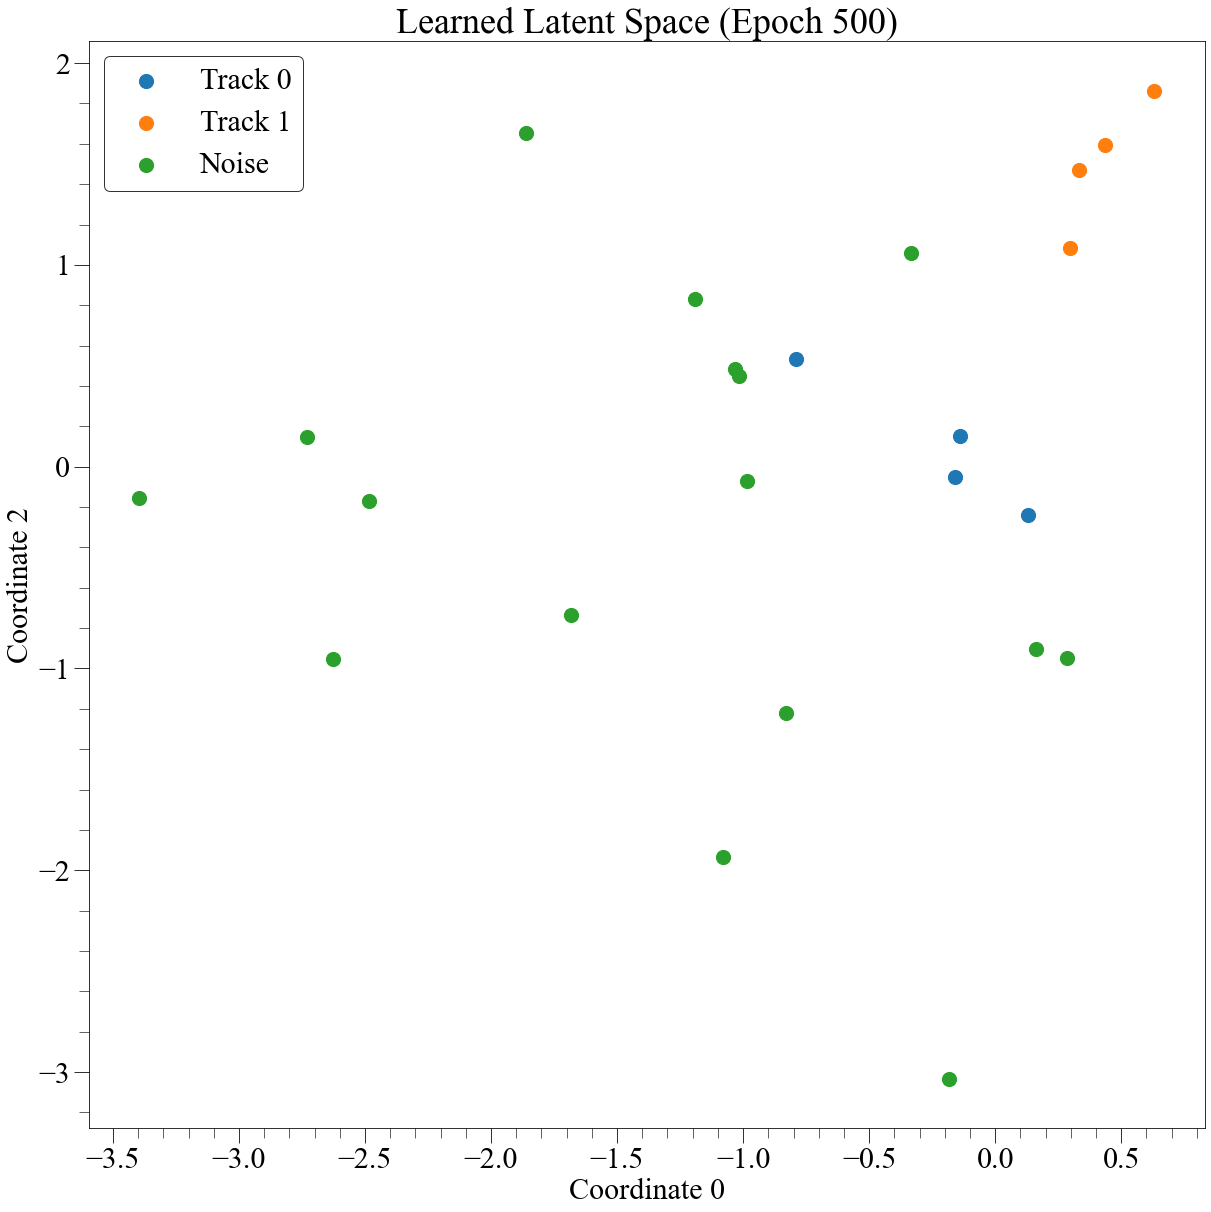

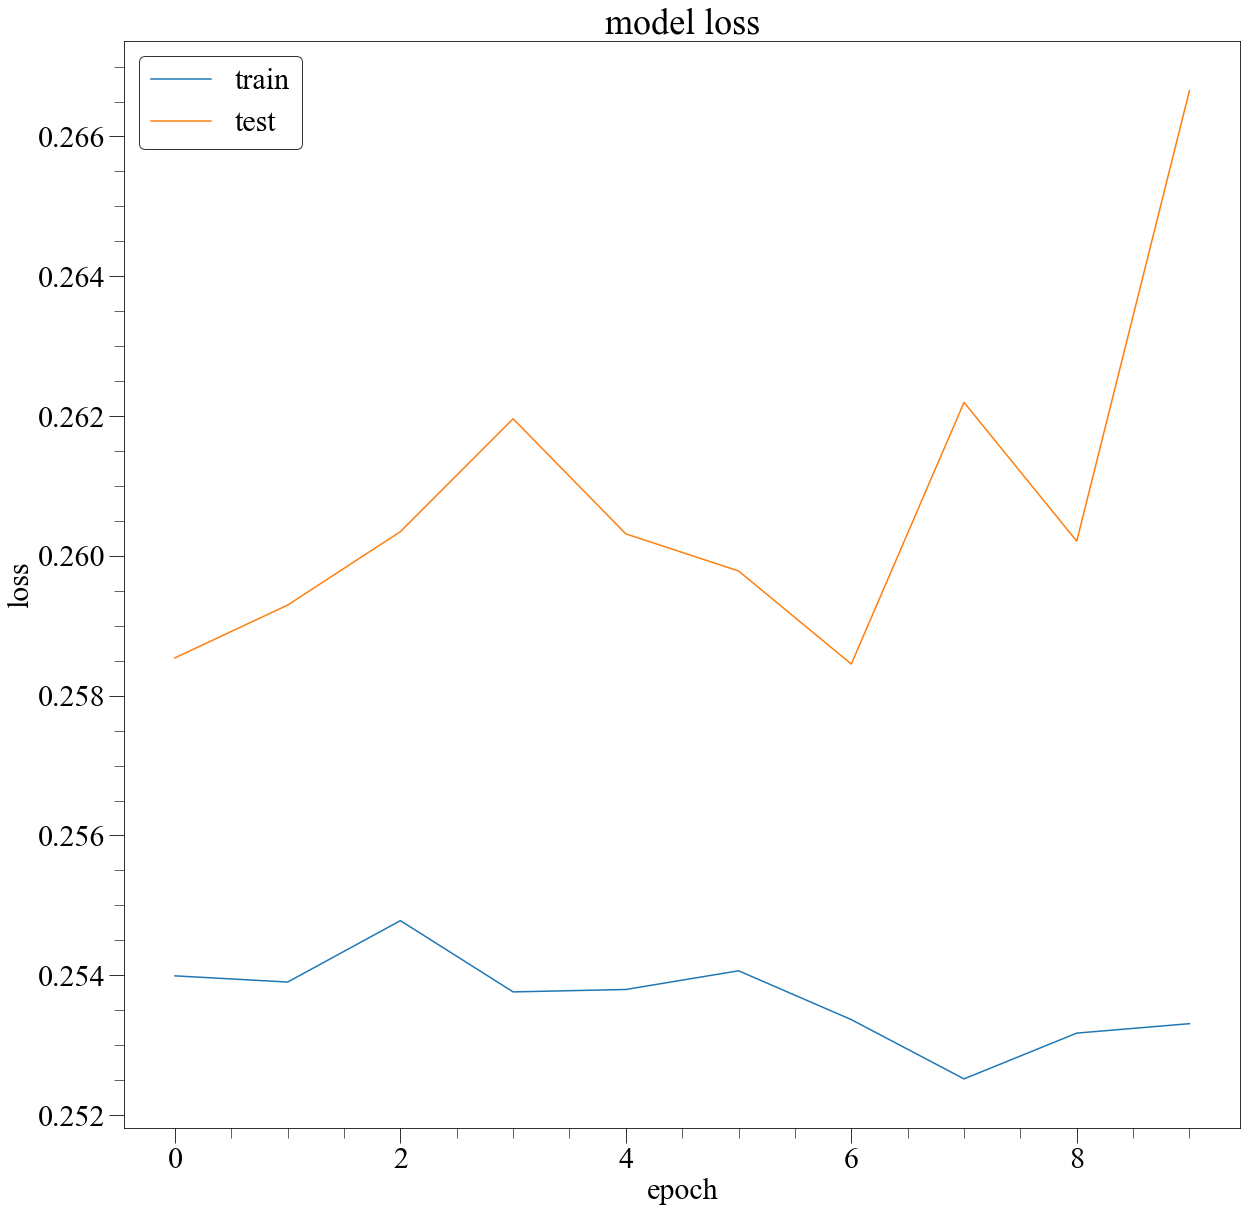

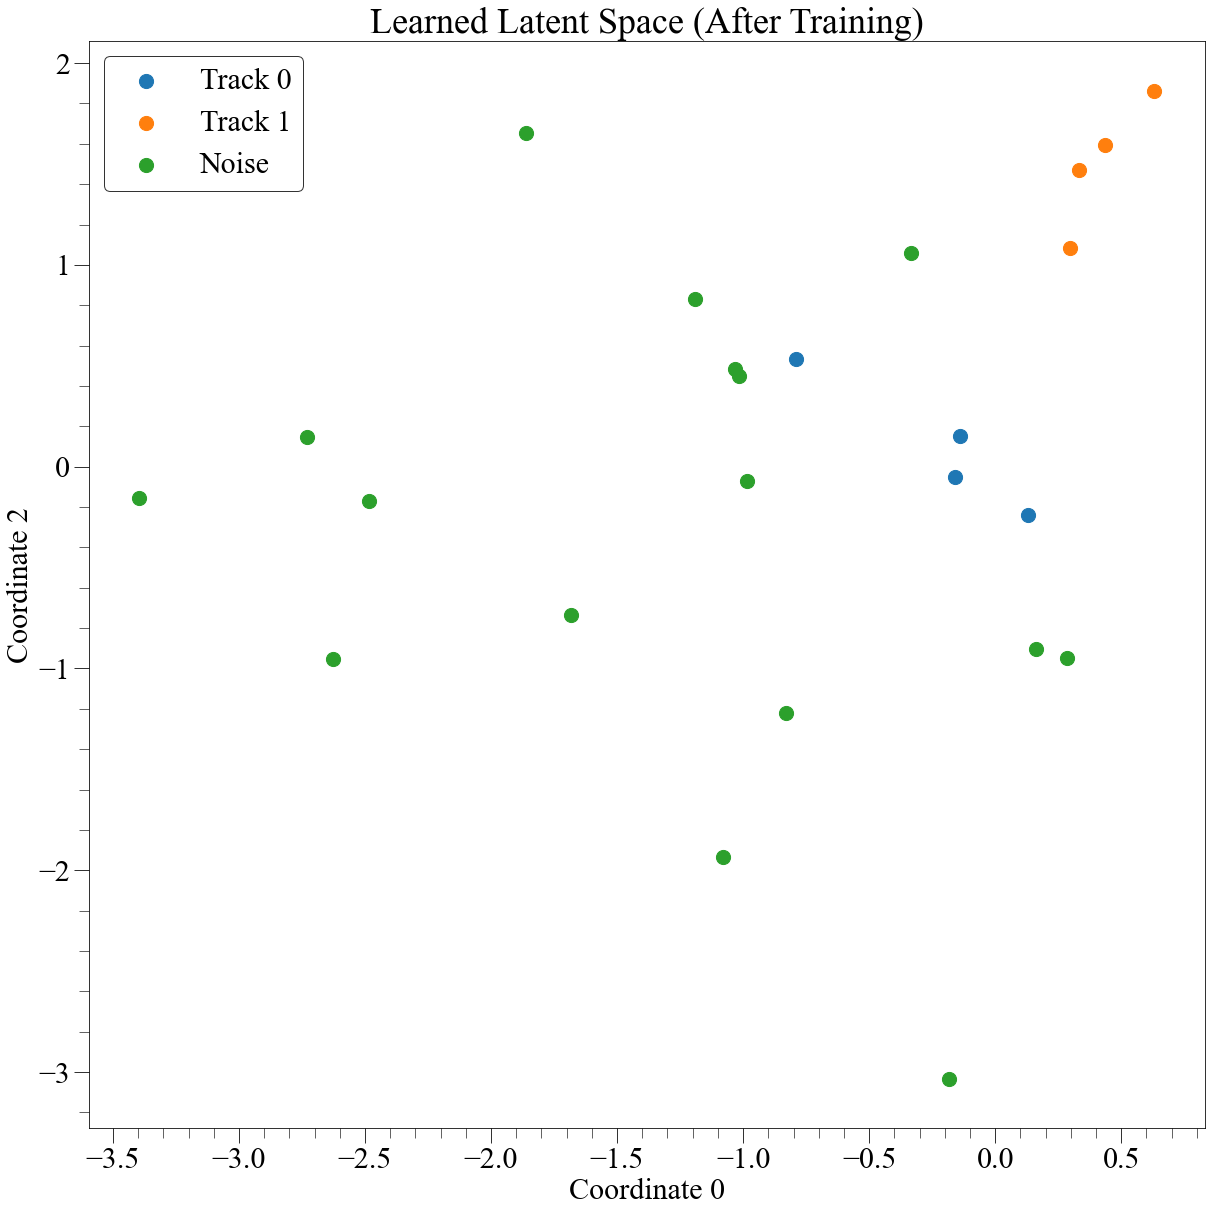

In [34]:
#print(train_hits)
GNet_track_identifier=train_GNet_trackID(train_hits,train_size,train_truth)

In [ ]:
true_tracks,event_array=genEvent(depth,width,height,nbTracks,resolution,nbNoise,allow_overlap)
    
hits,size,truth=get_hits_GNet(event_array,width,height,depth,vmax,true_tracks)

pred=GNet_track_identifier.predict(hits)

plot_latent_space(pred,truth,'',nbTracks)

In [ ]:
nb_test_events=100

AvEff=0
AvPur=0

for i in range(nb_test_events):
    
    if (i%100)==0:
        print('Generated '+str(i)+' events')

    true_tracks,event_array=genEvent(depth,width,height,nbTracks,resolution,nbNoise,allow_overlap)

    #vmax needs to be the same as training, otherwise input size won't be consistent with trained model
    hits,size=get_hits_GNet(event_array,width,height,depth,vmax,true_tracks)
    
    #track_candidates=norm(track_candidates,width,height)
    
    predicted_tracks=apply_GNet_trackID(GNet_track_identifier,hits,size)

    #predicted_tracks=unnorm_GNet(predicted_tracks,width,height,nbTracks)
    
    if i==0:
        print('')
        print('True Tracks, size: '+str(true_tracks.shape[0]))
        print(true_tracks)
        print('')
        print('Predicted Tracks, size: '+str(predicted_tracks.shape[0]))
        print(predicted_tracks)
        print('')
        event_array_2=np.zeros((height,width,4))
        addTracks(event_array_2,predicted_tracks,1)
        plotEvent(event_array,width,height,ticks)
        plotEvent(event_array_2,width,height,ticks)

    eff,pur=calculate_GNet_metrics(true_tracks,predicted_tracks)
    #print(eff)
    #print(pur)
    AvEff=AvEff+eff
    AvPur=AvPur+pur
    
AvEff=AvEff/nb_test_events
AvPur=AvPur/nb_test_events


print('')
print('Fraction of predicted true tracks over N true tracks '+str(AvEff))
print('Fraction of predicted fake tracks over N true tracks '+str(AvPur))
print('')